In [ ]:
def process_gap_folders_for_filters(base_folder, df, filterp=False, scalep=False,np=1):
    """
    Processes gap folders and adds time series data to given dataframes.

        base_folder (str): The base folder containing gap folders.
        df (pd.DataFrame): The dataframe with gap information.
        series_dataframe (pd.DataFrame): Dataframe to add gap time series data to.
        random_series_dataframe (pd.DataFrame): Dataframe to add random time series data to.
        np: number of random points, default is 3
    """
    # Create a list of all folders/filepaths for all gaps
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    start_date = datetime(2017, 11, 11)
    end_date = datetime.now()
    date_range = pd.date_range(start_date, end_date, freq='D')

    dataframe_list=[]
    ## iterate over number of points, create a dataframe for each point
    for point in range(np):

        ## initialize dataframe by previously defined date range
        random_series_dataframe = pd.DataFrame(index=date_range)


        # Iterate over each gap folder and process the data
        for gap_folder in gap_folders:

            gap_number = int(gap_folder.split('gap')[-1])
            center_coord = read_gap_coordinates(gap_number, df)
            random_series_dataframe = add_random_time_series_to_df(random_series_dataframe, gap_folder, center_coord, num_points=1, radius=200, attribute_table=df, filterp=filterp, scalep=scalep)

        dataframe_list.append(random_series_dataframe)

    return dataframe_list


def lee_filter(data):
    """Apply Lee filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')
    
    noise_variance = np.var(data)  # Estimate noise variance from the entire data

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data[t, 0] - local_mean[0])
    
    return filtered_data

In [2]:
# Basic Libraries
import os
import glob
import numpy as np
import pandas as pd
import random
import math
from datetime import datetime
import warnings

# Plotting Libraries
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
import matplotlib.lines as mlines


# Image Processing
import rasterio
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float

# Signal Processing and Statistics
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import skew, kurtosis, entropy as scipy_entropy
from scipy.stats import entropy as scipy_entropy
from statsmodels.tsa.stattools import adfuller
from scipy.ndimage import median_filter
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform


# Time Series Analysis and Filtering
from pykalman import KalmanFilter
import nolds
from scipy.signal import wiener
import bm3d
from tqdm import tqdm
from scipy.ndimage import uniform_filter


# Coordinate Transformation
from pyproj import Transformer

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import roc_curve, roc_auc_score
import xgboost as xgb




In [3]:
# Add MiKTeX bin directory to PATH
os.environ['PATH'] += os.pathsep + r'C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64'

# Verify the update
print("Updated PATH:")
print(os.environ['PATH'])

# Print LaTeX configuration
print("LaTeX configuration:")
print(os.popen("latex --version").read())


Updated PATH:
c:\Users\olive\AppData\Local\Programs\Python\Python311;c:\Users\olive\AppData\Roaming\Python\Python311\Scripts;C:\Program Files\Common Files\Oracle\Java\javapath;C:\Program Files (x86)\Common Files\Oracle\Java\java8path;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0\;C:\WINDOWS\System32\OpenSSH\;C:\Program Files\Git\cmd;C:\Program Files\dotnet\;C:\Program Files\Pandoc\;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64;C:\Users\olive\AppData\Local\Programs\Python\Python311\Scripts;C:\Users\olive\AppData\Local\Programs\Python\Python311;C:\Users\olive\AppData\Local\Microsoft\WindowsApps;C:\Users\olive\AppData\Local\Programs\Microsoft VS Code\bin;C:\Program Files\esa-snap\bin;C:\Users\olive\AppData\Local\Programs\MiKTeX\miktex\bin\x64\;C:\Prog

In [4]:
# Set specific font sizes
plt.rcParams.update({
    'font.size': 12,          # Global font size
    'axes.titlesize': 11,     # Title font size
    'axes.labelsize': 11,     # X and Y axis labels font size
    'xtick.labelsize': 9,    # X-axis tick labels font size
    'ytick.labelsize': 9,    # Y-axis tick labels font size
    'legend.fontsize': 10,    # Legend font size
})
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [5]:
df=pd.read_csv('saved_attribute_table.csv')
attribute_table2=pd.read_csv('attribute_table_2.csv')

In [6]:
# Ensure the 'fid' column is the index in both dataframes
df.set_index('fid', inplace=True)
attribute_table2.set_index('fid', inplace=True)

# Update the centroid_x and centroid_y columns in df with the values from attribute_table2
df.update(attribute_table2[['centroid_x', 'centroid_y']])

# Reset the index to return 'fid' as a column
df.reset_index(inplace=True)

In [7]:
def check_forest_mask(tif_path, utm_x, utm_y, proj):
    """
    Returns forest coverage for a given point
    
    Parameters:
    tif_path (str): The path to the forest coverage file.
    utm_x (float): The UTM easting coordinate.
    utm_y (float): The UTM northing coordinate.
    
    Returns:
    int: Forest coverage percentage
    """

    with rasterio.open(tif_path) as dataset:
        # Initialize the transformer
        transformer_to_raster_crs = Transformer.from_crs(proj, dataset.crs, always_xy=True)
        
        # Convert UTM coordinates to the raster's CRS
        raster_x, raster_y = transformer_to_raster_crs.transform(utm_x, utm_y)
        
        # Calculate the pixel coordinates
        pixel_col, pixel_row = ~dataset.transform * (raster_x, raster_y)
        pixel_col = int(pixel_col)
        pixel_row = int(pixel_row)

        
        # Check if the pixel coordinates are within the raster's dimensions
        if 0 <= pixel_col < dataset.width and 0 <= pixel_row < dataset.height:
            # Read the value at the pixel coordinates
            data = dataset.read(1, window=((pixel_row, pixel_row + 1), (pixel_col, pixel_col + 1)))
            pixel_value = data[0, 0]
            return pixel_value
        else:
            return None



def generate_random_coordinates(center, radius, num_points=10):
    """
    Generate random coordinates within a given radius from a center point.
    
    Parameters:
    center (tuple): A tuple containing the UTM coordinates of the center point (easting, northing).
    radius (float): The radius within which to generate the random points (in meters).
    num_points (int): The number of random points to generate. Default is 10.
    
    Returns:
    list: A list of tuples containing the UTM coordinates of the random points.
    """
    center_easting, center_northing = center
    points = []
    valid_points = 0

    if str(center_easting).startswith('21'):
        tif_path = '00N_060W.tif'
        proj='EPSG:29181'
    else:
        tif_path = '00N_070W.tif'
        proj='EPSG:32720'


    while valid_points < num_points:
        angle = random.uniform(0, 2 * math.pi)
        distance = random.uniform(0, radius)
        
        offset_easting = distance * math.cos(angle)
        offset_northing = distance * math.sin(angle)
        
        new_easting = center_easting + offset_easting
        new_northing = center_northing + offset_northing
        
        pixel_value = check_forest_mask(tif_path, new_easting, new_northing,proj)
        
        if pixel_value == 100:  ## verify its forest
            points.append((new_easting, new_northing))
            valid_points += 1
        else:
            continue
    
    return points

In [8]:
def list_tif_files(folder_path):
    return sorted(glob.glob(os.path.join(folder_path, '*.tif')))

In [9]:
def utm_to_pixel(dataset, utm_x, utm_y):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x), int(pixel_y)

In [10]:
def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [11]:
def read_gap_coordinates(gap_number, df):
    """
    Given a gap number, return the centroid coordinates from the DataFrame.
    
    Parameters:
    gap_number (int): The gap number (1-based index).
    df (pd.DataFrame): The DataFrame containing the coordinates.
    
    Returns:
    tuple: A tuple containing the (x, y) coordinates.
    """
    # Convert 1-based index to 0-based index
    row_index = gap_number - 1
    
    # Get the coordinates from the DataFrame
    x_coord = df.at[row_index, 'centroid_x']
    y_coord = df.at[row_index, 'centroid_y']
    
    return (x_coord, y_coord)

# Example usage
gap_number = 82
coordinates = read_gap_coordinates(gap_number, df)
print(f"Coordinates for gap{gap_number}: {coordinates}")

Coordinates for gap82: (217941.875567938, 9551027.85076804)


In [12]:
def extract_time_series_for_coordinate(folder_path, coord, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    # Loop through each .tif file
    for tif_file in tif_files:
        # Extract the date from the filename
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        # Get pixel value for the specified coordinate
        coord_value = get_pixel_value(tif_file, coord[0], coord[1], filter != 'False')
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    # Apply the chosen filter
    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)  # Extract the smoothed state estimates
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values


def extract_time_series_for_random_points(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    random_points_time_series = [[] for _ in range(num_points)]

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            coord_value = get_pixel_value(tif_file, utm_x, utm_y, filter != 'False')
            random_points_time_series[i].append(coord_value)

    if scale:
        random_points_time_series = [[10**(value / 10) for value in series] for series in random_points_time_series]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            kf = KalmanFilter(initial_state_mean=random_points_time_series[i][0], n_dim_obs=1)
            random_points_time_series[i], _ = kf.smooth(random_points_time_series[i])  # Extract the smoothed state estimates
            random_points_time_series[i] = random_points_time_series[i].flatten()
    elif filter == 'savgol':
        random_points_time_series = [savgol_filter(series, window_length=5, polyorder=2) for series in random_points_time_series]

    return dates, random_points_time_series


def get_pixel_value(tif_file, utm_x, utm_y, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        # Read the image data
        band1 = dataset.read(1)
        
        if apply_filter:
            # Convert to float for the filter
            band1_float = img_as_float(band1)
            # Estimate the noise standard deviation from the data
            sigma_est = np.mean(estimate_sigma(band1_float))
            # Apply the Non-Local Means (NLM) filter
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            # Use the denoised image
            image_data = denoised_band1
        else:
            # Use the original image
            image_data = band1

        # Convert UTM point to pixel coordinates
        pixel_x, pixel_y = utm_to_pixel(dataset, utm_x, utm_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value

In [13]:
folder_path = 'downloaded_files/gap83'
coord = read_gap_coordinates(83,df)
dates, coord_values = extract_time_series_for_random_points(folder_path, coord,100,10, filter=False, scale=True)

In [14]:
def add_time_series_to_df(series_dataframe_, gap_folder, attribute_table,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])
    
    # Get the coordinates for the current gap folder
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    
    # Extract the time series data for the current gap folder
    dates, coord_values = extract_time_series_for_coordinate(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    # Create a DataFrame for the current gap folder
    gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}': coord_values})
    
    # Set the 'Date' column as the index
    gap_df.set_index('Date', inplace=True)
    
    # Merge with the main DataFrame, aligning on the 'Date' index
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def add_random_time_series_to_df(series_dataframe_, gap_folder, center_coord, num_points=3, radius=100, attribute_table=None,filterp=False,scalep=False):
    # Extract gap number from the folder name
    gap_number = int(gap_folder.split('gap')[-1])

    # Extract the time series data for random points in the current gap folder
    dates, random_points_time_series = extract_time_series_for_random_points(gap_folder, center_coord, radius, num_points, filter=filterp, scale=scalep)

    # Create a DataFrame for the random points time series
    for i in range(num_points):
        gap_df = pd.DataFrame({'Date': dates, f'gap{gap_number}_random{i+1}': random_points_time_series[i]})
        gap_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')

    return series_dataframe_

In [15]:
def process_gap_folders(base_folder, df, series_dataframe, random_series_dataframe, filterp=False, scalep=False,np=3):
    """
    Processes gap folders and adds time series data to given dataframes.

        base_folder (str): The base folder containing gap folders.
        df (pd.DataFrame): The dataframe with gap information.
        series_dataframe (pd.DataFrame): Dataframe to add gap time series data to.
        random_series_dataframe (pd.DataFrame): Dataframe to add random time series data to.
        np: number of random points, default is 3
    """
    # Create a list of all folders/filepaths for all gaps
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    # Iterate over each gap folder and process the data
    for gap_folder in gap_folders:
        series_dataframe = add_time_series_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

        gap_number = int(gap_folder.split('gap')[-1])
        center_coord = read_gap_coordinates(gap_number, df)
        random_series_dataframe = add_random_time_series_to_df(random_series_dataframe, gap_folder, center_coord, num_points=np, radius=200, attribute_table=df, filterp=filterp, scalep=scalep)

    return series_dataframe, random_series_dataframe

# Extract time series for neighbours functions

In [16]:
start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [22]:
# Function to convert UTM coordinates to pixel coordinates with an offset
def unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x=0, offset_y=0):
    transform = dataset.transform
    inv_transform = ~transform
    pixel_x, pixel_y = inv_transform * (utm_x, utm_y)
    return int(pixel_x) + offset_x, int(pixel_y) + offset_y


# Function to get pixel value from a TIF file for a given UTM coordinate
def unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x=0, offset_y=0, apply_filter=False):
    with rasterio.open(tif_file) as dataset:
        band1 = dataset.read(1)
        
        if apply_filter:
            band1_float = img_as_float(band1)
            sigma_est = np.mean(estimate_sigma(band1_float))
            denoised_band1 = denoise_nl_means(band1_float, h=1.15 * sigma_est, fast_mode=True,
                                              patch_size=5, patch_distance=6)
            image_data = denoised_band1
        else:
            image_data = band1

        pixel_x, pixel_y = unique_utm_to_pixel(dataset, utm_x, utm_y, offset_x, offset_y)
        pixel_value = image_data[pixel_y, pixel_x]
        return pixel_value


# Function to extract time series for a given coordinate
def unique_extract_time_series_for_coordinate(folder_path, coord, offset_x=0, offset_y=0, filter='False', scale=False):
    tif_files = list_tif_files(folder_path)
    dates = []
    coord_values = []

    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        coord_value = unique_get_pixel_value(tif_file, coord[0], coord[1], offset_x, offset_y, apply_filter=(filter != 'False'))
        coord_values.append(coord_value)

    if scale:
        coord_values = [10**(value / 10) for value in coord_values]

    if filter == 'kalman':
        kf = KalmanFilter(initial_state_mean=coord_values[0], n_dim_obs=1)
        coord_values, _ = kf.smooth(coord_values)
        coord_values = coord_values.flatten()
    elif filter == 'savgol':
        coord_values = savgol_filter(coord_values, window_length=5, polyorder=2)

    return dates, coord_values

# Function to extract time series for surrounding pixels
def unique_extract_time_series_for_surrounding_pixels(folder_path, central_coord, filter='False', scale=False):
    offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]  # Center, above, below, left, right, top left, top right, bottom left, bottom right
    all_time_series = []
    dates = None

    for offset_x, offset_y in offsets:
        current_dates, current_series = unique_extract_time_series_for_coordinate(folder_path, central_coord, offset_x, offset_y, filter, scale)
        if dates is None:
            dates = current_dates
        all_time_series.append(current_series)

    return dates, all_time_series

# Function to add time series with surrounding pixels to DataFrame
def unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe_, gap_folder, attribute_table, filterp=False, scalep=False):
    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)
    dates, all_coord_values = unique_extract_time_series_for_surrounding_pixels(gap_folder, gap_coord, filter=filterp, scale=scalep)
    
    labels = ['centre', 'above', 'below', 'left', 'right','top_left', 'top_right', 'bottom_left','bottom_right']
    data = {f'gap{gap_number}_{label}': values for label, values in zip(labels, all_coord_values)}
    data['Date'] = dates

    gap_df = pd.DataFrame(data)
    gap_df.set_index('Date', inplace=True)
    series_dataframe_ = series_dataframe_.merge(gap_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_

# Function to process gap folders and add time series data to DataFrame
def unique_process_gap_folders_with_surrounding_pixels(base_folder, df, series_dataframe, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_with_surrounding_pixels_to_df(series_dataframe, gap_folder, df, filterp=filterp, scalep=scalep)

    return series_dataframe


In [23]:
def extract_time_series_for_random_points_with_neighbors(folder_path, center_coord, radius, num_points, filter='False', scale=False):
    # Generate random coordinates within the specified radius
    random_points = generate_random_coordinates(center_coord, radius, num_points)
    all_time_series_random = []

    # List all TIF files in the folder
    tif_files = list_tif_files(folder_path)
    dates = []

    # Initialize the nested list structure
    for i in range(num_points):
        all_time_series_random.append([[] for _ in range(9)])

    # Extract time series for each random point and its neighbors
    for tif_file in tif_files:
        date_str = os.path.basename(tif_file).split('-')[-3] + '-' + os.path.basename(tif_file).split('-')[-2] + '-' + os.path.basename(tif_file).split('-')[-1].split('.')[0]
        date = datetime.strptime(date_str, '%Y-%m-%d')
        dates.append(date)

        for i, (utm_x, utm_y) in enumerate(random_points):
            offsets = [(0, 0), (0, 1), (0, -1), (-1, 0), (1, 0), (-1, 1), (1, 1), (-1, -1), (1, -1)]  # Center, above, below, left, right, top left, top right, bottom left, bottom right

            for j, (offset_x, offset_y) in enumerate(offsets):
                coord_value = unique_get_pixel_value(tif_file, utm_x, utm_y, offset_x, offset_y, filter != 'False')
                all_time_series_random[i][j].append(coord_value)

    if scale:
        all_time_series_random = [[[10**(value / 10) for value in series] for series in point_series] for point_series in all_time_series_random]

    # Apply the chosen filter
    if filter == 'kalman':
        for i in range(num_points):
            for j in range(5):
                kf = KalmanFilter(initial_state_mean=all_time_series_random[i][j][0], n_dim_obs=1)
                all_time_series_random[i][j], _ = kf.smooth(all_time_series_random[i][j])
                all_time_series_random[i][j] = all_time_series_random[i][j].flatten()
    elif filter == 'savgol':
        all_time_series_random = [[savgol_filter(series, window_length=5, polyorder=2) for series in point_series] for point_series in all_time_series_random]

    return dates, all_time_series_random



def unique_add_time_series_for_random_points_to_df(series_dataframe_, gap_folder,attribute_table, radius=50, num_points=3, filterp=False, scalep=False):

    gap_number = int(gap_folder.split('gap')[-1])
    gap_coord = read_gap_coordinates(gap_number, attribute_table)

    ## DOES THE FOLLOWING LINE NEED TO BE HERE:
    # I WILL COMMENT IT OUT FOR NOW
    # dates, all_coord_values = unique_extract_time_series_for_surrounding_pixels(gap_folder, gap_coord, filter=filterp, scale=scalep)

    # Extract the time series data for random points and their neighbors
    dates, all_time_series_random = extract_time_series_for_random_points_with_neighbors(gap_folder, gap_coord, radius, num_points, filter=filterp, scale=scalep)
    
    labels = ['centre', 'above', 'below', 'left', 'right','top_left', 'top_right', 'bottom_left','bottom_right']
    
    for i in range(num_points):
        data = {f'gap{gap_number}_random{i+1}_{label}': values for label, values in zip(labels, all_time_series_random[i])}
        data['Date'] = dates
        
        random_df = pd.DataFrame(data)
        random_df.set_index('Date', inplace=True)
        series_dataframe_ = series_dataframe_.merge(random_df, left_index=True, right_index=True, how='outer')
    
    return series_dataframe_


def unique_process_gap_folders_with_surrounding_pixels_random(base_folder, df, series_dataframe,radius,num_points, filterp=False, scalep=False):
    gap_folders = [os.path.join(base_folder, folder) for folder in os.listdir(base_folder) if folder.startswith('gap')]

    for gap_folder in gap_folders:
        print(gap_folder)
        series_dataframe = unique_add_time_series_for_random_points_to_df(series_dataframe, gap_folder, df,radius=50,num_points=3, filterp=filterp, scalep=scalep)

    return series_dataframe



In [24]:
df_series_2yr_gaps_with_neighbours = unique_process_gap_folders_with_surrounding_pixels('downld_2yr_12dayinterval', df, df_gen1, filterp=False, scalep=False)

downld_2yr_12dayinterval\gap1
downld_2yr_12dayinterval\gap10
downld_2yr_12dayinterval\gap100
downld_2yr_12dayinterval\gap101
downld_2yr_12dayinterval\gap102
downld_2yr_12dayinterval\gap103
downld_2yr_12dayinterval\gap104
downld_2yr_12dayinterval\gap105
downld_2yr_12dayinterval\gap106
downld_2yr_12dayinterval\gap107
downld_2yr_12dayinterval\gap11
downld_2yr_12dayinterval\gap12
downld_2yr_12dayinterval\gap13
downld_2yr_12dayinterval\gap14
downld_2yr_12dayinterval\gap15
downld_2yr_12dayinterval\gap16
downld_2yr_12dayinterval\gap17
downld_2yr_12dayinterval\gap18
downld_2yr_12dayinterval\gap19
downld_2yr_12dayinterval\gap2
downld_2yr_12dayinterval\gap20
downld_2yr_12dayinterval\gap21
downld_2yr_12dayinterval\gap22
downld_2yr_12dayinterval\gap23
downld_2yr_12dayinterval\gap24
downld_2yr_12dayinterval\gap25
downld_2yr_12dayinterval\gap26
downld_2yr_12dayinterval\gap27
downld_2yr_12dayinterval\gap28
downld_2yr_12dayinterval\gap29
downld_2yr_12dayinterval\gap3
downld_2yr_12dayinterval\gap30
dow

In [25]:
df_series_2yr_random_with_neighbours=unique_process_gap_folders_with_surrounding_pixels_random('downld_2yr_12dayinterval',df,df_gen1,50,3)

downld_2yr_12dayinterval\gap1
downld_2yr_12dayinterval\gap10
downld_2yr_12dayinterval\gap100
downld_2yr_12dayinterval\gap101
downld_2yr_12dayinterval\gap102
downld_2yr_12dayinterval\gap103
downld_2yr_12dayinterval\gap104
downld_2yr_12dayinterval\gap105
downld_2yr_12dayinterval\gap106
downld_2yr_12dayinterval\gap107
downld_2yr_12dayinterval\gap11
downld_2yr_12dayinterval\gap12
downld_2yr_12dayinterval\gap13
downld_2yr_12dayinterval\gap14
downld_2yr_12dayinterval\gap15
downld_2yr_12dayinterval\gap16
downld_2yr_12dayinterval\gap17
downld_2yr_12dayinterval\gap18
downld_2yr_12dayinterval\gap19
downld_2yr_12dayinterval\gap2
downld_2yr_12dayinterval\gap20
downld_2yr_12dayinterval\gap21
downld_2yr_12dayinterval\gap22
downld_2yr_12dayinterval\gap23
downld_2yr_12dayinterval\gap24
downld_2yr_12dayinterval\gap25
downld_2yr_12dayinterval\gap26
downld_2yr_12dayinterval\gap27
downld_2yr_12dayinterval\gap28
downld_2yr_12dayinterval\gap29
downld_2yr_12dayinterval\gap3
downld_2yr_12dayinterval\gap30
dow

## Create time series dataframes

In [27]:
## form generic dataframes ##

start_date = datetime(2017, 11, 11)
end_date = datetime.now()
date_range = pd.date_range(start_date, end_date, freq='D')

df_gen1 = pd.DataFrame(index=date_range)
df_gen2 = pd.DataFrame(index=date_range)

In [28]:
#df_series_alltime_gaps, df_series_alltime_random = process_gap_folders('downloaded_files', df, df_gen1, df_gen2, filterp=False, scalep=False)

#df_series_2yr_gaps, df_series_2yr_random = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp=False, scalep=False)

#df_series_2yr_gaps_filtered_kalman , df_series_2yr_random_filtered_kalman = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp='kalman', scalep=False)
#df_series_2yr_gaps_filtered_savgol , df_series_2yr_random_filtered_savgol = process_gap_folders('downld_2yr_12dayinterval', df, df_gen1, df_gen2, filterp='savgol', scalep=False)

In [29]:
## Shorten the indefinete / alltime random dataframe so we can compare

def keep_first_two_years(df):
    df_copy = df.copy()
    for column in df_copy.columns:
        # Find the first non-NaN entry in the column
        first_valid_index = df_copy[column].first_valid_index()
        
        if first_valid_index is not None:
            # Calculate the date two years after the first non-NaN entry
            cutoff_date = first_valid_index + pd.DateOffset(years=2)
            
            # Set all entries after the cutoff date to NaN
            df_copy.loc[df_copy.index > cutoff_date, column] = pd.NA

    return df_copy

# Applying the function to the dataframe
#df_series_alltime_random_reduced = keep_first_two_years(df_series_alltime_random)

## Analyse slopes on time series

In [30]:
# Function to plot aggregate statistics for two dataframes on a single plot
def plot_aggregates(df1, df2, title1, title2, df3, df4, title3, title4):
    # Calculate the mean and standard deviation for the first dataframe set
    mean_series1 = df1.mean(axis=1, skipna=True).dropna()
    std_series1 = df1.std(axis=1, skipna=True).dropna()
    
    mean_series2 = df2.mean(axis=1, skipna=True).dropna()
    std_series2 = df2.std(axis=1, skipna=True).dropna()
    
    # Calculate the mean and standard deviation for the second dataframe set
    mean_series3 = df3.mean(axis=1, skipna=True).dropna()
    std_series3 = df3.std(axis=1, skipna=True).dropna()
    
    mean_series4 = df4.mean(axis=1, skipna=True).dropna()
    std_series4 = df4.std(axis=1, skipna=True).dropna()
    
    # Plot the results
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.2, 5.5), sharex=True)
    
    # Plot for the first dataframe set
    ax1.plot(mean_series1, label=f'{title1} Mean', color='#FF0000')
    # ax1.fill_between(mean_series1.index, mean_series1 - std_series1, mean_series1 + std_series1, color='blue', alpha=0.2, label=f'{title1} Standard Deviation')
    
    ax1.plot(mean_series2, label=f'{title2} Mean', color='#0000FF')
    # ax1.fill_between(mean_series2.index, mean_series2 - std_series2, mean_series2 + std_series2, color='green', alpha=0.2, label=f'{title2} Standard Deviation')
    
    ax1.legend()
    ax1.grid(True)
    ax1.set_ylabel('Pixel Values')
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')

    
    # Plot for the second dataframe set
    ax2.plot(mean_series3, label=f'{title3} Mean', color='#FF0000')
    # ax2.fill_between(mean_series3.index, mean_series3 - std_series3, mean_series3 + std_series3, color='blue', alpha=0.2, label=f'{title3} Standard Deviation')
    
    ax2.plot(mean_series4, label=f'{title4} Mean', color='#0000FF')
    # ax2.fill_between(mean_series4.index, mean_series4 - std_series4, mean_series4 + std_series4, color='green', alpha=0.2, label=f'{title4} Standard Deviation')
    
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Pixel Values')
    ax2.legend()
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()


In [31]:
#plot_aggregates(df_series_alltime_gaps, df_series_alltime_random, 'Indefinite Gaps', 'Indefinite Random',df_series_2yr_gaps, df_series_alltime_random_reduced, '2 year Gaps', '2 year Random')
#plt.savefig('series_lineplot_double.pdf')

## Filtering and Time Series Length

### Create Filter Time Series Dataframes

In [32]:
## function to eliminate neighbour points from dataframes for comparison
def rename_for_compare(dfx):

    df = dfx.copy()
    # Filter columns to keep only those with 'centre'
    centre_cols = [col for col in df.columns if 'centre' in col]
    df_centre_only = df[centre_cols]

    # Rename columns to remove '_centre' part
    new_col_names = [col.replace('_centre', '') for col in df_centre_only.columns]
    df_centre_only.columns = new_col_names

    return df_centre_only


def filter_and_rename_columns(df):
    # Filter columns to keep only those with '_centre'
    centre_columns = [col for col in df.columns if col.endswith('_centre')]
    
    # Rename columns by removing '_centre'
    new_column_names = {col: col.replace('_centre', '') for col in centre_columns}
    
    # Select the filtered columns and rename them
    filtered_df = df[centre_columns].rename(columns=new_column_names)
    
    return filtered_df

def calculate_image_variance(file_path):
    """Load the image from the file path and calculate the variance of the pixel values."""
    with rasterio.open(file_path) as src:
        image = src.read(1)  # Read the first band
    return np.var(image)

## ALL FILTERING FUNCTIONS

def create_datacube(df, gap_number,random_id=0, gap=True):
    """
    Converts a DataFrame with 9 columns into a 3D array for filtering for a specific gap number.
    
    Parameters:
    df (pd.DataFrame): Input DataFrame with SAR data having multiple gaps or random points.
    gap_number (int): The number of the gap or random points columns to be extracted (e.g., 1, 5).
    gap (bool): If True, handles gap points; if False, handles random points.
    
    Returns:
    np.ndarray: 3D array (3x3xt) where t is the number of rows in the DataFrame.
    """
    if gap:
        # Define the correct order of the columns for the specified gap
        column_order = [
            f'gap{gap_number}_top_left', f'gap{gap_number}_above', f'gap{gap_number}_top_right', 
            f'gap{gap_number}_left', f'gap{gap_number}_centre', f'gap{gap_number}_right', 
            f'gap{gap_number}_bottom_left', f'gap{gap_number}_below', f'gap{gap_number}_bottom_right'
        ]
    else:
        # Define the correct order of the columns for the specified random points
        column_order = [
            f'gap{gap_number}_random{random_id}_top_left', f'gap{gap_number}_random{random_id}_above', f'gap{gap_number}_random{random_id}_top_right', 
            f'gap{gap_number}_random{random_id}_left', f'gap{gap_number}_random{random_id}_centre', f'gap{gap_number}_random{random_id}_right', 
            f'gap{gap_number}_random{random_id}_bottom_left', f'gap{gap_number}_random{random_id}_below', f'gap{gap_number}_random{random_id}_bottom_right'
        ]
    
    # Ensure the DataFrame has the required columns
    for col in column_order:
        if col not in df.columns:
            raise ValueError(f"The DataFrame does not have the required column: {col}")
    
    # Number of time steps
    t = df.shape[0]
    
    # Initialize the 3D array
    datacube = np.zeros((3, 3, t))
    
    # Populate the 3D array
    for i in range(t):
        values = df.iloc[i][column_order].values
        datacube[:, :, i] = values.reshape((3, 3))
    
    return datacube


def dB_to_linear(db_array):
    """Convert dB to linear scale."""
    return 10 ** (db_array / 10)

def linear_to_dB(linear_array):
    """Convert linear scale to dB."""
    ans = 10 * np.log10(linear_array)
    return ans


def frost_filter(data, damping_factor=0.05):
    """Apply Frost filter to a 2D array with time series in rows and 9 columns for neighbors."""
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        local_variance = np.clip(local_variance, a_min=1e-8, a_max=None)  # Avoid division by zero
        center_value = data[t, :]
        
        # Calculate coefficients
        coefficients = np.exp(-damping_factor * np.abs(local_window - center_value) * local_variance / local_mean**2)
        weights = coefficients / np.sum(coefficients, axis=0)
        
        # Apply weights to the local window to get the filtered value
        filtered_data[t] = np.sum(weights * local_window, axis=0)[0]


    return filtered_data


def lee_filter(data):
    """Apply Lee filter to a 2D array with time series in rows and 9 columns for neighbors."""
    column_name = data.columns[0]
    gap_name = column_name.split('_')[0]

    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data.values, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t, date in enumerate(data.index):

        # Construct the file path
        date_str = date.strftime('%Y-%m-%d')
        file_path = f'downld_2yr_12dayinterval/{gap_name}/{gap_name}-{date_str}.tif'
        
        # Verify the file path and calculate the image variance
        if not os.path.isfile(file_path):
            print(f"File not found: {file_path}")
            noise_variance = np.var(data.values)  # Fallback to variance from the data if file not found
        else:
            noise_variance = calculate_image_variance(file_path)

        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data.values[t, 0] - local_mean[0])
    
    return filtered_data


def adaptive_wiener_filter(data):
    """Apply Adaptive Wiener filter to a 2D array with time series in rows and 9 columns for neighbors."""

    
    filtered_data = np.zeros(data.shape[0])
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (0, 0)), mode='edge')

    for t in range(data.shape[0]):
        local_window = padded_data[t:t + 3, :]
        local_mean = np.mean(local_window, axis=0)
        local_variance = np.var(local_window, axis=0)
        noise_variance = np.var(data)
        k = local_variance / (local_variance + noise_variance)
        filtered_data[t] = local_mean[0] + k[0] * (data[t, 0] - local_mean[0])

    return filtered_data


def quegan_filter(dataframe,gap_number,random_id=0,gap=True):


    datacube = create_datacube(dataframe, gap_number,random_id, gap)
    
    # Calculate temporal mean for each pixel
    temporal_mean = np.mean(datacube, axis=2)[:,:,np.newaxis]
    
    # Calculate temporal variance for each pixel
    temporal_var = np.var(datacube, axis=2)[:,:,np.newaxis]
    
    # Calculate filter strength
    k = 1 - (temporal_var / (temporal_mean ** 2 + temporal_var))
    
    # Apply filter to all time steps at once
    filtered_cube = k * temporal_mean + (1 - k) * datacube


    return filtered_cube[1,1,:]


def apply_median_temporal_filter(df, window_size=3):
    """Apply a median temporal filter to the time series in the dataframe."""
    filtered_df = pd.DataFrame(index=df.index)
    
    for col in df.columns:
        # Convert from dB to linear scale
        time_series = df[col].values
        
        # Drop NaNs and keep the index for restoring later
        non_nan_series = df[col].dropna()
        non_nan_index = non_nan_series.index
        non_nan_values = dB_to_linear(non_nan_series.values)
        
        # Apply the median filter
        filtered_non_nan_values = median_filter(non_nan_values, size=window_size)
        
        # Convert back to dB scale
        filtered_non_nan_db = linear_to_dB(filtered_non_nan_values)
        
        # Create a series to hold the filtered values, reintroducing NaNs where appropriate
        filtered_series = pd.Series(data=np.nan, index=df.index)
        filtered_series[non_nan_index] = filtered_non_nan_db
        
        # Store the filtered time series in the output DataFrame
        filtered_df[col] = filtered_series
    
    return filtered_df


def quegan_filter3d(dataframe, gap_number, random_id=0, gap=True, time_window_size=3):
    """
    Apply 3D Quegan filter to the datacube and return the filtered center pixel values.
    
    Parameters:
    dataframe (pd.DataFrame): Input DataFrame with SAR data.
    gap_number (int): The number of the gap or random points columns to be extracted.
    random_id (int): The random point id to be used if gap is False.
    gap (bool): If True, handles gap points; if False, handles random points.
    time_window_size (int): Size of the time window for filtering (default: 3).
    
    Returns:
    np.ndarray: 1D array of filtered center pixel values.
    """
    
    datacube = create_datacube(dataframe, gap_number, random_id, gap)
    
    # Convert the datacube from dB to linear scale for processing
    datacube_linear = dB_to_linear(datacube)
    
    spatial_window_size = 3
    pad_width_spatial = spatial_window_size // 2
    pad_width_time = time_window_size // 2
    
    padded_cube = np.pad(datacube_linear, ((pad_width_spatial,), (pad_width_spatial,), (pad_width_time,)), mode='edge')
    
    filtered_cube = np.zeros_like(datacube_linear)
    
    # Use numpy's stride tricks for efficient sliding window
    from numpy.lib.stride_tricks import sliding_window_view
    windows = sliding_window_view(padded_cube, (spatial_window_size, spatial_window_size, time_window_size))
    
    for i in tqdm(range(datacube.shape[0])):
        for j in range(datacube.shape[1]):
            for k in range(datacube.shape[2]):
                local_window = windows[i, j, k]
                local_mean = np.mean(local_window)
                local_var = np.var(local_window)
                
                if local_var == 0 and local_mean == 0:
                    k_value = 0
                else:
                    k_value = 1 - (local_var / (local_var + local_mean**2))
                
                filtered_cube[i, j, k] = k_value * local_mean + (1 - k_value) * datacube_linear[i, j, k]
    
    # Convert the filtered datacube back to dB scale
    filtered_cube_dB = linear_to_dB(filtered_cube)

    
    return filtered_cube_dB[1, 1, :]


def quegan_filter3d(dataframe,gap_number,random_id,gap=True, spatial_window=3):
    """
    Apply a spatiotemporal Quegan filter to the datacube.
    
    Parameters:
    datacube (np.ndarray): Input 3D array with shape (height, width, time)
    spatial_window (int): Size of the spatial window (default: 3)
    
    Returns:
    np.ndarray: Filtered datacube
    """
    
    datacube = create_datacube(dataframe, gap_number,random_id, gap)

    filtered_cube = np.zeros_like(datacube, dtype=float)
    
    # Calculate spatiotemporal mean
    spatiotemporal_mean = uniform_filter(datacube, size=(spatial_window, spatial_window, datacube.shape[2]))
    
    # Calculate spatiotemporal variance
    spatiotemporal_var = uniform_filter(datacube**2, size=(spatial_window, spatial_window, datacube.shape[2])) - spatiotemporal_mean**2
    
    # Ensure variance is non-negative (floating point precision issues)
    spatiotemporal_var = np.maximum(spatiotemporal_var, 0)
    
    # Calculate filter strength
    k = 1 - (spatiotemporal_var / (spatiotemporal_mean**2 + spatiotemporal_var))
    
    # Apply filter
    filtered_cube = k * spatiotemporal_mean + (1 - k) * datacube
    
    return filtered_cube[1,1,:]


def quegan_frost(dataframe, gap_number, random_id=0, gap=True, damping_factor=1):
    datacube = create_datacube(dataframe, gap_number, random_id, gap)
    
    # Calculate temporal mean for each pixel
    temporal_mean = np.mean(datacube, axis=2)[:, :, np.newaxis]
    
    # Calculate temporal variance for each pixel
    temporal_var = np.var(datacube, axis=2)[:, :, np.newaxis]
    
    # Calculate filter strength
    k = 1 - (temporal_var / (temporal_mean ** 2 + temporal_var))
    
    # Apply filter to all time steps at once
    data = k * temporal_mean + (1 - k) * datacube

    # Initialize filtered data array
    filtered_data = np.zeros(data.shape)
    
    # Pad data for edge handling
    pad_size = 1
    padded_data = np.pad(data, ((pad_size, pad_size), (pad_size, pad_size), (0, 0)), mode='edge')

    # Iterate through spatial dimensions and time
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for t in range(data.shape[2]):
                # Extract local window
                local_window = padded_data[i:i + 3, j:j + 3, t]
                center_value = data[i, j, t]
                
                # Calculate local mean and variance
                local_mean = np.mean(local_window)
                local_variance = np.var(local_window)
                local_variance = np.clip(local_variance, a_min=1e-8, a_max=None)  # Avoid division by zero
                
                # Calculate coefficients
                coefficients = np.exp(-damping_factor * np.abs(local_window - center_value) * local_variance / local_mean**2)
                weights = coefficients / np.sum(coefficients)
                
                # Apply weights to the local window to get the filtered value
                filtered_data[i, j, t] = np.sum(weights * local_window)

    return filtered_data[1,1,:]



def process_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        cols = [f'gap{gap_id}_{label}' for label in labels]
        sub_df = df[cols]
        
        if sub_df.isnull().all().all():
            continue
        
        sub_df_linear = dB_to_linear(sub_df)
        sub_df_linear.dropna(inplace=True)
        
        if sub_df_linear.empty:
            continue

        
        if filter_type == 'frost':
            filtered_linear = frost_filter(sub_df_linear.values)
        elif filter_type == 'lee':
            filtered_linear = lee_filter(sub_df_linear)
        elif filter_type == 'quegan':
            filtered_linear = quegan_filter(sub_df_linear,gap_id,0,True)
        elif filter_type == 'quegan3d':
            filtered_linear = quegan_filter3d(sub_df_linear,gap_id,0,True)
        elif filter_type == 'quegan_frost':
            filtered_linear = quegan_frost(sub_df_linear,gap_id,0,True)

        
        filtered_db = linear_to_dB(filtered_linear)
        filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
        df_filtered[f'gap{gap_id}_centre'] = filtered_series
    
    return df_filtered


def process_random_dataframe(df, labels, filter_type):
    warnings.filterwarnings("ignore", message=".*DataFrame is highly fragmented.*")
    df_filtered = pd.DataFrame(index=df.index)
    
    for gap_id in range(1, 108):
        for random_id in range(1, 4):
            cols = [f'gap{gap_id}_random{random_id}_{label}' for label in labels]
            sub_df = df[cols]
            
            if sub_df.isnull().all().all():
                continue

            
            sub_df_linear = dB_to_linear(sub_df)
            sub_df_linear.dropna(inplace=True)
            
            if sub_df_linear.empty:
                continue
            
            if filter_type == 'frost':
                filtered_linear = frost_filter(sub_df_linear.values)
            elif filter_type == 'lee':
                filtered_linear = lee_filter(sub_df_linear)
            elif filter_type == 'quegan':
                filtered_linear = quegan_filter(sub_df_linear, gap_id, random_id, False)
            elif filter_type == 'quegan3d':
                filtered_linear = quegan_filter3d(sub_df_linear, gap_id, random_id, False)
            elif filter_type == 'quegan_frost':
                filtered_linear = quegan_frost(sub_df_linear, gap_id, random_id, False)
            
            filtered_db = linear_to_dB(filtered_linear)
            filtered_series = pd.Series(filtered_db, index=sub_df_linear.index)
            df_filtered[f'gap{gap_id}_random{random_id}_centre'] = filtered_series
    
    return df_filtered




In [35]:
## CREATION OF FILTERED DATAFRAMES
'''
IN GENERAL:
start with dataframes with neighbours: df_series_2yr_gaps_with_neighbours, df_series_2yr_random_with_neighbours
then put them through the relevant filters.
Changes slightly for temporal filters since neighbours arent needed
'''

labels = ['centre', 'above', 'below', 'left', 'right', 'top_left', 'top_right', 'bottom_left', 'bottom_right']


## COMPARISON / INITIAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_series_2yr_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)
df_series_2yr_random = rename_for_compare(df_series_2yr_random_with_neighbours)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('comparison done')

## FROST FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_frost_gaps = process_dataframe(df_series_2yr_gaps_with_neighbours, labels, 'frost')
df_frost_gaps = df_frost_gaps.reindex(df_gen1.index)

df_frost_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels, 'frost')
df_frost_random = df_frost_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('frost done')

## LEE FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_lee_gaps = process_dataframe(df_series_2yr_gaps_with_neighbours, labels,'lee')
df_lee_gaps = df_lee_gaps.reindex(df_gen1.index)

df_lee_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels, 'lee')
df_lee_random = df_lee_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('lee done')

## TEMPORAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_temporal_gaps = rename_for_compare(df_series_2yr_gaps_with_neighbours)
df_temporal_gaps = apply_median_temporal_filter(df_temporal_gaps)
df_temporal_gaps = df_temporal_gaps.reindex(df_gen1.index)

df_series_2yr_random_for_filter_comparison = rename_for_compare(df_series_2yr_random_with_neighbours)
df_temporal_random = apply_median_temporal_filter(df_series_2yr_random_for_filter_comparison)
df_temporal_random = df_temporal_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal done')

## TEMPORAL LEE FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
# apply temporal filter to whole neighbours time series, then apply lee filter
df_temporal_lee_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_temporal_lee_random = df_series_2yr_random_with_neighbours.copy()

df_temporal_lee_gaps = apply_median_temporal_filter(df_temporal_lee_gaps)
df_temporal_lee_gaps = process_dataframe(df_temporal_lee_gaps, labels, 'lee')
df_temporal_lee_gaps = df_temporal_lee_gaps.reindex(df_gen1.index)

df_temporal_lee_random=apply_median_temporal_filter(df_temporal_lee_random)
df_temporal_lee_random=process_random_dataframe(df_temporal_lee_random,labels,'lee')
df_temporal_lee_random=df_temporal_lee_random.reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal lee done')


## LEE TEMPORAL FILTERS~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
# apply temporal filter on already filtered lee filter time series
#df_lee_temporal_gaps=apply_median_temporal_filter(df_lee_gaps.copy())
#df_lee_temporal_random=apply_median_temporal_filter(df_lee_random.copy())
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#print('lee temporal done')


## TEMPORAL FROST~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_temporal_frost_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_temporal_frost_random=df_series_2yr_random_with_neighbours.copy()

df_temporal_frost_gaps = apply_median_temporal_filter(df_temporal_frost_gaps)
df_temporal_frost_gaps = process_dataframe(df_temporal_frost_gaps, labels, 'frost').reindex(df_gen1.index)

df_temporal_frost_random = apply_median_temporal_filter(df_temporal_frost_random)
df_temporal_frost_random = process_random_dataframe(df_temporal_frost_random, labels, 'frost').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('temporal frost done')


## QUEGAN FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_quegan_gaps=process_dataframe(df_series_2yr_gaps_with_neighbours,labels,'quegan').reindex(df_gen1.index)
df_quegan_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels,'quegan').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan done')


## QUEGAN FROST FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
## NB ITS LABELED TEMPORAL QUEGAN
df_quegan_frost_gaps=df_series_2yr_gaps_with_neighbours.copy()
df_quegan_frost_random = df_series_2yr_random_with_neighbours.copy()

df_quegan_frost_gaps = process_dataframe(df_quegan_frost_gaps, labels, 'quegan_frost').reindex(df_gen1.index)
df_quegan_frost_random=process_random_dataframe(df_quegan_frost_random,labels,'quegan_frost').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan frost done')


## QUEGAN 3d FILTER~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~##
df_quegan3d_gaps=process_dataframe(df_series_2yr_gaps_with_neighbours,labels,'quegan3d').reindex(df_gen1.index)
df_quegan3d_random=process_random_dataframe(df_series_2yr_random_with_neighbours,labels,'quegan3d').reindex(df_gen1.index)
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
print('quegan 3d done')

comparison done
frost done
lee done
temporal done
temporal lee done
temporal frost done
quegan done
quegan frost done
quegan 3d done


In [36]:
def extract_features(df, label):
    features = []
    for col in df.columns:
        series = df[col].dropna()  # Drop NaNs for feature calculation
        if not series.empty:
            mean_val = series.mean()
            var_val = series.var()
            skew_val = skew(series)
            max_val = series.max()
            min_val = series.min()
            range_val = max_val - min_val

            features.append({
                'name': col,
                'mean': mean_val,
                'variance': var_val,
                'skewness': skew_val,
                'max': max_val,
                'min': min_val,
                'range': range_val,
                'gap': label
            })

    return pd.DataFrame(features)

def create_feature_matrix(gap_df, random_df, area_df):
    # Make copies of the dataframes to avoid modifying the original ones
    gap_df = gap_df.copy()
    random_df = random_df.copy()
    area_df = area_df.copy()

    # Extract features for both dataframes
    gap_features = extract_features(gap_df, label=1)
    random_features = extract_features(random_df, label=0)

    # Add a zero-indexed row number to area_df
    area_df['row_index'] = area_df.index

    # Extract the numeric part of the 'name' column from gap_features
    gap_features['name_index'] = gap_features['name'].str.extract('(\d+)').astype(int)

    # Merge based on the row number
    gap_features = gap_features.merge(area_df[['row_index', 'area']], left_on='name_index', right_on='row_index', how='left')
    gap_features = gap_features.drop(columns=['row_index', 'name_index'])

    # Add area column to random_features with NaN values
    random_features['area'] = np.nan

    # Combine the features into a single DataFrame
    X_df = pd.concat([gap_features, random_features], ignore_index=True)

    return X_df


In [37]:
## NOW CREATE FEATURE DATAFRAMES AFTER FILTERED TIME SERIES HAVE BEEN CREATED

#X_df_alltime = create_feature_matrix(df_series_alltime_gaps, df_series_alltime_random, df)

X_df_2yr = create_feature_matrix(df_series_2yr_gaps, df_series_2yr_random, df)

#X_df_2yr_reduced = create_feature_matrix(df_series_2yr_gaps,df_series_alltime_random_reduced, df)

X_df_2yr_frost = create_feature_matrix(df_frost_gaps, df_frost_random,df)

X_df_2yr_lee = create_feature_matrix(df_lee_gaps, df_lee_random,df)

X_df_2yr_temporal = create_feature_matrix(df_temporal_gaps,df_temporal_random,df)

X_df_2yr_temporal_lee = create_feature_matrix(df_temporal_lee_gaps, df_temporal_lee_random,df)

#X_df_2yr_lee_temporal = create_feature_matrix(df_lee_temporal_gaps,df_lee_temporal_random,df)

#X_df_2yr_frost_temporal = create_feature_matrix(df_)

X_df_2yr_temporal_frost = create_feature_matrix(df_temporal_frost_gaps,df_temporal_frost_random,df)

X_df_2yr_quegan = create_feature_matrix(df_quegan_gaps,df_quegan_random,df)

X_df_2yr_quegan_frost = create_feature_matrix(df_quegan_frost_gaps, df_quegan_frost_random, df)

X_df_2yr_quegan3d = create_feature_matrix(df_quegan3d_gaps, df_quegan3d_random, df)


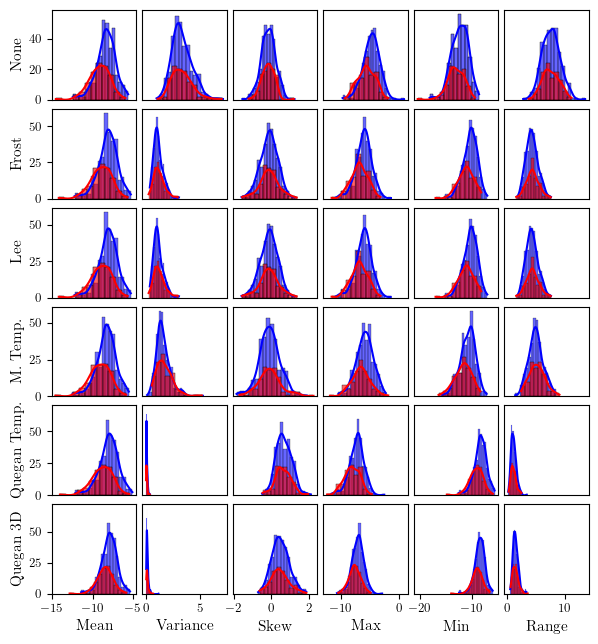

In [337]:
def plot_feature_distributions_strip(dfs, y_labels):
    # Select the columns to plot
    features = ['mean', 'variance', 'skewness', 'max', 'min', 'range']
    
    # Define the custom color palette
    palette = {0: 'blue', 1: 'red'}
    
    # Define the custom labels for the x-axis
    x_labels = {
        'mean': 'Mean',
        'variance': 'Variance',
        'skewness': 'Skew',
        'max': 'Max',
        'min': 'Min',
        'range': 'Range'
    }
    
    # Create a figure with subplots
    num_dfs = len(dfs)
    fig, axes = plt.subplots(num_dfs, len(features), figsize=(6.15, 1.1 * num_dfs), sharex='col', sharey='row')
    
    # Plot histograms for each feature in each dataframe
    for row, (df__, y_label) in enumerate(zip(dfs, y_labels)):
        for col, feature in enumerate(features):
            sns.histplot(data=df__[df__['gap'] == 0], x=feature, kde=True, ax=axes[row, col], color='blue', alpha=0.6, label='0')
            sns.histplot(data=df__[df__['gap'] == 1], x=feature, kde=True, ax=axes[row, col], color='red', alpha=0.6, label='1')
            
            if row == num_dfs - 1:
                axes[row, col].set_xlabel(x_labels[feature])  # Set the custom x-axis label for the bottom row
                axes[row, col].tick_params(axis='x', which='both', bottom=True)  # Show x-ticks only on the bottom row
            else:
                axes[row, col].set_xlabel('')
                axes[row, col].tick_params(axis='x', which='both', bottom=False)  # Hide x-ticks on other rows
            
            if col == 0:
                axes[row, col].set_ylabel(y_label)  # Set the custom y-axis label for each row
                axes[row, col].tick_params(axis='y', which='both', left=True)  # Show y-ticks only on the leftmost column
            else:
                axes[row, col].set_ylabel('')
                axes[row, col].tick_params(axis='y', which='both', left=False)  # Hide y-ticks on other columns

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.07, hspace=0.1)  # Adjust the space between the plots

# Example usage:
# Assuming your DataFrames are named X_df_2yr, X_df_2yr_frost, X_df_2yr_lee, X_df_2yr_temporal, X_df_2yr_quegan, and X_df_2yr_quegan3d
X_df_2yr_list = [X_df_2yr, X_df_2yr_frost, X_df_2yr_lee, X_df_2yr_temporal, X_df_2yr_quegan, X_df_2yr_quegan3d]
y_labels = ['None', 'Frost', 'Lee', 'M. Temp.', 'Quegan Temp.', 'Quegan 3D']
plot_feature_distributions_strip(X_df_2yr_list, y_labels)
plt.savefig('distribution_strip.pdf')


In [38]:
def mean_var_axis1(df):

    '''
    calculate mean and variance for each date
    effectively the 'average' time series
    '''

    mean=df.mean(axis=1)
    variance=df.var(axis=1)

    return(mean,variance)


def mean_var_axis0(df):
    
    '''
    calculates mean and variance for each time series
    acts down columns
    '''

    mean=df.mean(axis=0)
    variance=df.var(axis=0)

    return(mean,variance)


def aggregate_and_ensemble_vals(df):
    
    ### calculate 'average' time series
    m1,v1=mean_var_axis0(df)
    ensemble_mean=np.mean(m1)
    ensemble_var=np.var(m1)

    ### calculate mean of each time series
    m2,v2=mean_var_axis1(df)
    aggregate_mean=np.mean(m2)
    aggregate_var=np.var(m2)

    return((ensemble_mean,ensemble_var),(aggregate_mean,aggregate_var))

In [39]:
df_series_2yr_random1 = pd.DataFrame()
df_series_2yr_random2 = pd.DataFrame()
df_series_2yr_random3 = pd.DataFrame()

df_series_2yr_random1_frost = pd.DataFrame()
df_series_2yr_random2_frost = pd.DataFrame()
df_series_2yr_random3_frost = pd.DataFrame()

df_series_2yr_random1_lee = pd.DataFrame()
df_series_2yr_random2_lee = pd.DataFrame()
df_series_2yr_random3_lee = pd.DataFrame()

df_series_2yr_random1_temporal = pd.DataFrame()
df_series_2yr_random2_temporal = pd.DataFrame()
df_series_2yr_random3_temporal = pd.DataFrame()

df_series_2yr_random1_temporal_lee = pd.DataFrame()
df_series_2yr_random2_temporal_lee = pd.DataFrame()
df_series_2yr_random3_temporal_lee = pd.DataFrame()

df_series_2yr_random1_temporal_frost = pd.DataFrame()
df_series_2yr_random2_temporal_frost = pd.DataFrame()
df_series_2yr_random3_temporal_frost = pd.DataFrame()

df_series_2yr_random1_quegan = pd.DataFrame()
df_series_2yr_random2_quegan = pd.DataFrame()
df_series_2yr_random3_quegan = pd.DataFrame()

df_series_2yr_random1_quegan_frost = pd.DataFrame()
df_series_2yr_random2_quegan_frost = pd.DataFrame()
df_series_2yr_random3_quegan_frost = pd.DataFrame()

df_series_2yr_random1_quegan3d = pd.DataFrame()
df_series_2yr_random2_quegan3d = pd.DataFrame()
df_series_2yr_random3_quegan3d = pd.DataFrame()


# Separate columns based on their suffix (random1, random2, random3)
for col in df_series_2yr_random_for_filter_comparison.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3[col] = df_series_2yr_random_for_filter_comparison[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_frost[col] = df_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

# Separate columns based on their suffix (random1, random2, random3)
for col in df_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_lee[col] = df_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_random.columns:
    if col.endswith('_random1'):
        df_series_2yr_random1_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2'):
        df_series_2yr_random2_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3'):
        df_series_2yr_random3_temporal[col] = df_temporal_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_lee_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_temporal_lee[col] = df_temporal_lee_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_temporal_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_temporal_frost[col] = df_temporal_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan[col] = df_quegan_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan_frost_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan_frost[col] = df_quegan_frost_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

for col in df_quegan3d_random.columns:
    if col.endswith('_random1_centre'):
        df_series_2yr_random1_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random2_centre'):
        df_series_2yr_random2_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
    elif col.endswith('_random3_centre'):
        df_series_2yr_random3_quegan3d[col] = df_quegan3d_random[col]
        warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [40]:
#alltime_dfs = [df_series_alltime_gaps, [df_series_alltime_random1, df_series_alltime_random2, df_series_alltime_random3]]
_2yr_dfs = [df_series_2yr_gaps, [df_series_2yr_random1,df_series_2yr_random2,df_series_2yr_random3]]

_2yr_dfs_frost = [df_frost_gaps, [df_series_2yr_random1_frost,df_series_2yr_random2_frost,df_series_2yr_random3_frost]]
_2yr_dfs_lee = [df_lee_gaps, [df_series_2yr_random1_lee,df_series_2yr_random2_lee,df_series_2yr_random3_lee]]
_2yr_dfs_temporal = [df_temporal_gaps, [df_series_2yr_random1_temporal,df_series_2yr_random2_temporal,df_series_2yr_random3_temporal]]
_2yr_dfs_temporal_lee = [df_temporal_lee_gaps, [df_series_2yr_random1_temporal_lee,df_series_2yr_random2_temporal_lee,df_series_2yr_random3_temporal_lee]]
_2yr_dfs_temporal_frost = [df_temporal_frost_gaps, [df_series_2yr_random1_temporal_frost,df_series_2yr_random2_temporal_frost,df_series_2yr_random3_temporal_frost]]
_2yr_dfs_quegan = [df_quegan_gaps, [df_series_2yr_random1_quegan,df_series_2yr_random2_quegan,df_series_2yr_random3_quegan]]
_2yr_dfs_temporal_quegan = [df_quegan_frost_gaps, [df_series_2yr_random1_quegan_frost,df_series_2yr_random2_quegan_frost,df_series_2yr_random3_quegan_frost]]
_2yr_dfs_quegan3d = [df_quegan3d_gaps, [df_series_2yr_random1_quegan3d,df_series_2yr_random2_quegan3d,df_series_2yr_random3_quegan3d]]

In [41]:
def extract_variances(dfs):
    variances = []
    for df in dfs:
        _, variance = mean_var_axis0(df)
        variances.append(variance)
    return variances

def plot_boxplots(alltime_dfs, _2yr_dfs):
    # Extract variances for each set of dataframes
    variances_alltime = extract_variances([alltime_dfs[0]] + alltime_dfs[1])
    variances_2yr = extract_variances([_2yr_dfs[0]] + _2yr_dfs[1])
    
    # Combine all variances for plotting
    data_alltime = variances_alltime
    data_2yr = variances_2yr

    # Labels for the boxplots
    labels_alltime = ['Gap', 'Random 1', 'Random 2', 'Random 3']
    labels_2yr = ['Gap', 'Random 1', 'Random 2', 'Random 3']

    fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharey=True)

    # Boxplot properties
    boxprops = dict(facecolor='blue', color='black')
    medianprops = dict(color='red', linewidth=2)
    whiskerprops = dict(color='black', linewidth=2)
    capprops = dict(color='black', linewidth=2)
    flierprops = dict(marker='o', color='blue', alpha=0.5)
    
    # Boxplot for Alltime dataframes
    bp_alltime = axs[0].boxplot(data_alltime, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[0].set_xticklabels(labels_alltime, rotation=45)
    axs[0].set_ylabel('Variance')
    axs[0].set_title('(a)')
    axs[0].grid(True)

    # Boxplot for 2-Year dataframes
    bp_2yr = axs[1].boxplot(data_2yr, patch_artist=True, boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops, showmeans=True)
    axs[1].set_xticklabels(labels_2yr, rotation=45)
    axs[1].set_title('(b)')
    axs[1].grid(True)

    # Customize the mean points
    for mean in bp_alltime['means']:
        mean.set(marker='o', color='red', markersize=7)
    for mean in bp_2yr['means']:
        mean.set(marker='o', color='red', markersize=7)

    plt.tight_layout()

#plot_boxplots(alltime_dfs, _2yr_dfs)
#plt.savefig('boxplot_variance.pdf')

In [42]:
def plot_side_by_side(dfs1, dfs2, dfs3, labels1, labels2, labels3):
    fig, axs = plt.subplots(1, 3, figsize=(6, 3), sharex=True, sharey=True)

    # Initialize lists to hold all the scatter points for x and y
    all_x = []
    all_y = []

    def plot_scatter(ax, gap_df, random_dfs, color_gap, color_random):
        (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(gap_df)
        all_x.extend([ensemble_mean, aggregate_mean])
        all_y.extend([ensemble_var, aggregate_var])
        ax.scatter(ensemble_mean, ensemble_var, color=color_gap, marker='x', s=100, label='Gap - Ensemble')
        ax.scatter(aggregate_mean, aggregate_var, color=color_gap, marker='x', s=50, label='Gap - Aggregate')
        for df in random_dfs:
            (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(df)
            all_x.extend([ensemble_mean, aggregate_mean])
            all_y.extend([ensemble_var, aggregate_var])
            ax.scatter(ensemble_mean, ensemble_var, color=color_random, marker='o', s=100, label='Random - Ensemble', alpha=0.5)
            ax.scatter(aggregate_mean, aggregate_var, color=color_random, marker='o', s=25, label='Random - Aggregate', alpha=0.5)

    # Plot for the first set of dataframes (Alltime)
    gap_df1, random_dfs1 = dfs1
    print(type(gap_df1),type(random_dfs1))
    plot_scatter(axs[0], gap_df1, random_dfs1, 'red', 'blue')
    axs[0].set_title(labels1)
    axs[0].set_xlabel('Mean')
    axs[0].set_ylabel('Variance')
    axs[0].grid()

    # Plot for the second set of dataframes (2-Year)
    gap_df2, random_dfs2 = dfs2
    plot_scatter(axs[1], gap_df2, random_dfs2, 'red', 'blue')
    axs[1].set_title(labels2)
    axs[1].set_xlabel('Mean')
    axs[1].grid()

    # Plot for the third set of dataframes (Third set)
    gap_df3, random_dfs3 = dfs3
    plot_scatter(axs[2], gap_df3, random_dfs3, 'red', 'blue')
    axs[2].set_title(labels3)
    axs[2].set_xlabel('Mean')
    axs[2].grid()

    # Compute the min and max for x and y with a 0.2 border
    x_min, x_max = min(all_x) - 0.3, max(all_x) + 0.3
    y_min, y_max = min(all_y) - 0.3, max(all_y) + 0.3

    for ax in axs:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Custom legend
    handles = [
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Ensemble', markerfacecolor='none', markeredgecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Aggregate', markerfacecolor='none', markeredgecolor='red', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Ensemble', markerfacecolor='blue', markeredgecolor='blue', markersize=12, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Aggregate', markerfacecolor='blue', markeredgecolor='blue', markersize=5, alpha=0.5)
    ]
    #fig.legend(handles=handles, loc='upper center', ncol=1, bbox_to_anchor=(0.55, 1.28))

    plt.tight_layout()

# Plotting the scatter plots
#labels_alltime = 'No filter (a)'
#labels_2yr = 'Frost Filter (b)'
#labels_3rd = 'Temp Lee Filter (c)'
#plot_side_by_side(_2yr_dfs, _2yr_dfs_frost, _2yr_dfs_quegan, labels_alltime, labels_2yr, labels_3rd)
#plt.savefig('filter_3_comparison.pdf')
#plt.show()

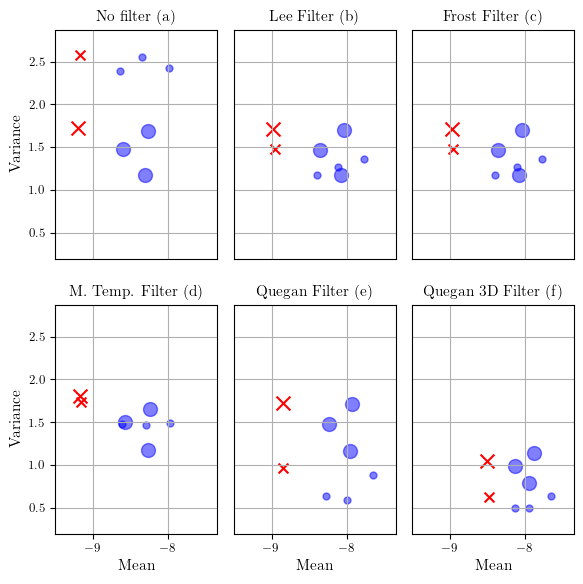

In [342]:
def plot_side_by_side_6(dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, labels1, labels2, labels3, labels4, labels5, labels6):
    fig, axs = plt.subplots(2, 3, figsize=(6, 6), sharex=True, sharey=True)

    # Initialize lists to hold all the scatter points for x and y
    all_x = []
    all_y = []

    def plot_scatter(ax, gap_df, random_dfs, color_gap, color_random):
        (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(gap_df)
        all_x.extend([ensemble_mean, aggregate_mean])
        all_y.extend([ensemble_var, aggregate_var])
        ax.scatter(ensemble_mean, ensemble_var, color=color_gap, marker='x', s=100, label='Gap - Ensemble')
        ax.scatter(aggregate_mean, aggregate_var, color=color_gap, marker='x', s=50, label='Gap - Aggregate')
        for df in random_dfs:
            (ensemble_mean, ensemble_var), (aggregate_mean, aggregate_var) = aggregate_and_ensemble_vals(df)
            all_x.extend([ensemble_mean, aggregate_mean])
            all_y.extend([ensemble_var, aggregate_var])
            ax.scatter(ensemble_mean, ensemble_var, color=color_random, marker='o', s=100, label='Random - Ensemble', alpha=0.5)
            ax.scatter(aggregate_mean, aggregate_var, color=color_random, marker='o', s=25, label='Random - Aggregate', alpha=0.5)

    # List of dataframes and labels
    dataframe_list = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6]
    labels_list = [labels1, labels2, labels3, labels4, labels5, labels6]

    # Plot for each set of dataframes
    for idx, (dfs, label) in enumerate(zip(dataframe_list, labels_list)):
        row, col = divmod(idx, 3)
        gap_df, random_dfs = dfs
        plot_scatter(axs[row, col], gap_df, random_dfs, 'red', 'blue')
        axs[row, col].set_title(label)
        if row == 1:
            axs[row, col].set_xlabel('Mean')
        else:
            axs[row, col].set_xlabel('')
            axs[row, col].tick_params(axis='x', which='both', bottom=False)
        if col == 0:
            axs[row, col].set_ylabel('Variance')
        else:
            axs[row, col].set_ylabel('')
            axs[row, col].tick_params(axis='y', which='both', left=False)
        axs[row, col].grid()

    # Compute the min and max for x and y with a 0.3 border
    x_min, x_max = min(all_x) - 0.3, max(all_x) + 0.3
    y_min, y_max = min(all_y) - 0.3, max(all_y) + 0.3

    for ax in axs.flat:
        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)

    # Custom legend
    handles = [
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Ensemble', markerfacecolor='none', markeredgecolor='red', markersize=10),
        plt.Line2D([0], [0], marker='x', color='w', label='Gap - Aggregate', markerfacecolor='none', markeredgecolor='red', markersize=5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Ensemble', markerfacecolor='blue', markeredgecolor='blue', markersize=12, alpha=0.5),
        plt.Line2D([0], [0], marker='o', color='w', label='Random - Aggregate', markerfacecolor='blue', markeredgecolor='blue', markersize=5, alpha=0.5)
    ]
    #fig.legend(handles=handles, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.1))

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Example usage:
# Assuming your DataFrames are named as follows

labels1 = 'No filter (a)'
labels2 = 'Lee Filter (b)'
labels3 = 'Frost Filter (c)'
labels4 = 'M. Temp. Filter (d)'
labels5 = 'Quegan Filter (e)'
labels6 = 'Quegan 3D Filter (f)'


plot_side_by_side_6(_2yr_dfs, _2yr_dfs_lee, _2yr_dfs_frost,_2yr_dfs_temporal,_2yr_dfs_quegan,_2yr_dfs_quegan3d, labels1,labels2,labels3,labels4, labels5, labels6)
plt.savefig('filter_6_comparison_scatter.pdf')
plt.show()


In [351]:
## REMOVE AREA COLUMN FROM FEATURE DATAFRAMES SO WE CAN PLOT
# only area is removed since its numerical, but areas are only present for gap datapoints, not random ones

X_df_2yr_clean=X_df_2yr.drop(columns=['area'],axis=1)
X_df_2yr_frost_clean=X_df_2yr_frost.drop(columns=['area'],axis=1)
X_df_2yr_lee_clean = X_df_2yr_lee.drop(columns=['area'],axis=1)
X_df_2yr_temporal_clean = X_df_2yr_temporal.drop(columns=['area'],axis=1)
X_df_2yr_temporal_frost_clean = X_df_2yr_temporal_frost.drop(columns=['area'],axis=1)
X_df_2yr_temporal_lee_clean=X_df_2yr_temporal_lee.drop(columns=['area'],axis=1)
X_df_2yr_quegan_clean=X_df_2yr_quegan.drop(columns=['area'],axis=1)
X_df_2yr_quegan_frost_clean=X_df_2yr_quegan_frost.drop(columns=['area'],axis=1)
X_df_2yr_quegan3d_clean=X_df_2yr_quegan3d.drop(columns=['area'],axis=1)

In [234]:
def dunn_index(X, labels):
    """
    Dunn index as the ratio of the minimum inter-cluster distance to the maximum intra-cluster distance.
    
    - High Dunn Index:  well-separated and compact clusters (good).
    - Low Dunn Index:  poorly separated and dispersed clusters (bad).
    
    Args:
        X (np.ndarray): Data points.
        labels (np.ndarray): Cluster labels for each data point.

    Returns:
        float: The Dunn Index score.
    """
    distances = squareform(pdist(X))
    unique_labels = np.unique(labels)
    
    intra_cluster_dists = []
    inter_cluster_dists = []
    
    for label in unique_labels:
        cluster_points = X[labels == label]
        if len(cluster_points) > 1:
            intra_cluster_dists.append(np.mean(pdist(cluster_points)))
        for other_label in unique_labels:
            if label != other_label:
                other_cluster_points = X[labels == other_label]
                inter_cluster_dists.append(np.min([np.linalg.norm(a - b) for a in cluster_points for b in other_cluster_points]))
                
    return np.min(inter_cluster_dists) / np.max(intra_cluster_dists)

def calculate_cluster_metrics(feature_matrix):
    """
    Calculate clustering metrics for a given feature matrix.

    This function computes the Silhouette Score, Davies-Bouldin Index, and Dunn Index to evaluate the quality of clustering.

    - Silhouette Score:
        - High Silhouette Score: Indicates well-separated clusters (good).
        - Low Silhouette Score: Indicates overlapping clusters (bad).
    - Davies-Bouldin Index:
        - Low Davies-Bouldin Index: Indicates well-separated and compact clusters (good).
        - High Davies-Bouldin Index: Indicates poorly separated and dispersed clusters (bad).
    - Dunn Index:
        - High Dunn Index: Indicates well-separated and compact clusters (good).
        - Low Dunn Index: Indicates poorly separated and dispersed clusters (bad).
    
    Args:
        feature_matrix (pd.DataFrame): DataFrame containing feature values and cluster labels.

    Returns:
        tuple: Silhouette Score, Davies-Bouldin Index, Dunn Index.
    """
    X = feature_matrix.drop(columns=['name', 'gap'])
    labels = feature_matrix['gap']

    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    dunn = dunn_index(X.values, labels.values)
    
    return silhouette, davies_bouldin, dunn


In [248]:
dataframes_list = [
    "X_df_2yr_clean", "X_df_2yr_frost_clean", "X_df_2yr_lee_clean", "X_df_2yr_temporal_clean",
    "X_df_2yr_temporal_lee_clean", "X_df_2yr_temporal_frost_clean", "X_df_2yr_quegan_clean","X_df_2yr_quegan3d_clean"
]

# Dictionary to store the results
results = {}

# Loop through each dataframe, calculate metrics and store the results
for df_name in dataframes_list:
    feature_df = globals()[df_name]
    silhouette, davies_bouldin, dunn = calculate_cluster_metrics(feature_df)
    results[df_name] = [silhouette, davies_bouldin, dunn]

# Create a dataframe from the results dictionary
metrics_df = pd.DataFrame(results, index=["Silhouette Score", "Davies-Bouldin Index", "Dunn Index"])

metrics_df.T

,Silhouette Score,Davies-Bouldin Index,Dunn Index
X_df_2yr_clean,0.037660,4.023448,0.005129
X_df_2yr_frost_clean,0.071455,3.335808,0.000614
X_df_2yr_lee_clean,0.071488,3.336063,0.000614
X_df_2yr_temporal_clean,0.060745,3.915573,0.000000
X_df_2yr_temporal_lee_clean,0.071471,3.409666,0.000000
X_df_2yr_temporal_frost_clean,0.071448,3.409334,0.000000
X_df_2yr_quegan_clean,0.083675,2.699308,0.002918
X_df_2yr_quegan3d_clean,0.048229,3.512939,0.003354


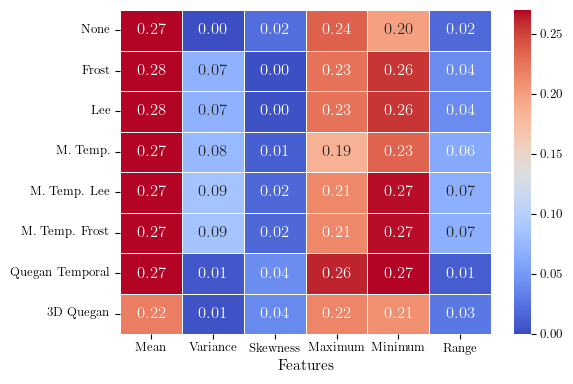

In [247]:
dataframes_list = [
    "X_df_2yr_clean", "X_df_2yr_frost_clean", "X_df_2yr_lee_clean", "X_df_2yr_temporal_clean",
    "X_df_2yr_temporal_lee_clean", "X_df_2yr_temporal_frost_clean", "X_df_2yr_quegan_clean","X_df_2yr_quegan3d_clean"
]

correlation_results = {}

# Loop through each DataFrame and calculate the absolute correlation with 'gap'
for df_name in dataframes_list:
    df = globals()[df_name]
    numeric_features = df.drop(columns=['name'])
    correlation_matrix = numeric_features.corr()
    gap_correlations = correlation_matrix.loc['gap'].drop('gap').abs()  # Taking the absolute value
    correlation_results[df_name] = gap_correlations

correlation_df = pd.DataFrame(correlation_results).T

# Define label mappings
df_label_mapping = {
    "X_df_2yr_clean": "None",
    "X_df_2yr_frost_clean": "Frost",
    "X_df_2yr_lee_clean": "Lee",
    "X_df_2yr_temporal_clean": "M. Temp.",
    "X_df_2yr_temporal_lee_clean": "M. Temp. Lee",
    "X_df_2yr_temporal_frost_clean": "M. Temp. Frost",
    "X_df_2yr_quegan_clean": "Quegan Temporal",
    "X_df_2yr_quegan3d_clean":'3D Quegan',
}

# Replace DataFrame labels
correlation_df.index = correlation_df.index.map(df_label_mapping)

# Replace feature names if needed (example feature mapping)
feature_label_mapping = {
    "mean": "Mean",
    "variance": "Variance",
    "skewness": "Skewness",
    "max": "Maximum",
    "min": "Minimum",
    "range": "Range"
}

correlation_df.columns = correlation_df.columns.map(feature_label_mapping)

# Plot the correlation summary table with absolute values
plt.figure(figsize=(6.1, 4))
sns.heatmap(correlation_df, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5, vmin=0, vmax=0.27)
plt.xlabel('Features')
plt.tight_layout()
plt.savefig('correlation_table.pdf')
plt.show()


In [327]:
def plot_top_to_bottom_scatter(X_df1, X_df2, title1, title2):
    # Create a figure with two subplots, one on top of the other
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6), sharex=True,sharey=True)
    
    # Plot for the first dataframe
    gap_points1 = X_df1[X_df1['gap'] == 1]
    non_gap_points1 = X_df1[X_df1['gap'] == 0]
    
    ax1.scatter(non_gap_points1['mean'], non_gap_points1['variance'], color='blue', marker='o', label='Random',s=20)
    ax1.scatter(gap_points1['mean'], gap_points1['variance'], color='red', marker='x', label='Gap',s=25)
    ax1.set_ylabel('Variance')
    ax1.legend(loc = 'upper left')
    ax1.grid(True)
    ax1.text(1.02, 0.5, '(a)', transform=ax1.transAxes, verticalalignment='center', fontweight='bold')


    # Plot for the second dataframe
    gap_points2 = X_df2[X_df2['gap'] == 1]
    non_gap_points2 = X_df2[X_df2['gap'] == 0]

    ax2.scatter(non_gap_points2['mean'], non_gap_points2['variance'], color='blue', marker='o', label='Random',s=20)
    ax2.scatter(gap_points2['mean'], gap_points2['variance'], color='red', marker='x', label='Gap',s=25)
    ax2.set_xlabel('Mean')
    ax2.set_ylabel('Variance')
    ax2.legend(loc = 'upper left')
    ax2.grid(True)
    ax2.text(1.02, 0.5, '(b)', transform=ax2.transAxes, verticalalignment='center', fontweight='bold')

    
    plt.tight_layout()

# Example usage
#plot_top_to_bottom_scatter(X_df_2yr, X_df_2yr_frost, 'All Time Data', '2 Year Data')
#plt.savefig('allscatter_double.pdf')

In [328]:
def perform_pca_and_plot_combined(X_df1, title1, X_df2, title2, X_df3, title3):
    # Define a helper function to perform PCA and return principal components and explained variance
    def perform_pca(X_df):
        features = X_df.drop(columns=['name', 'gap', 'area'], errors='ignore')
        pca = PCA(n_components=min(len(features.columns), 6))  # Adjust n_components to the number of features or 6
        principal_components = pca.fit_transform(features.fillna(0))  # Fill NaN with 0 for PCA
        pca_df = pd.DataFrame(data=principal_components, columns=[f'Principal Component {i+1}' for i in range(pca.n_components_)])
        pca_df['gap'] = X_df['gap']
        explained_variance = pca.explained_variance_ratio_
        return pca_df, explained_variance

    # Perform PCA on the three datasets
    pca_df1, explained_variance1 = perform_pca(X_df1)
    pca_df2, explained_variance2 = perform_pca(X_df2)
    pca_df3, explained_variance3 = perform_pca(X_df3)

    # Plot the PCA results side by side
    fig, axes = plt.subplots(2, 2, figsize=(6.1, 6.1))

    # Plot for the first dataset
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df1[pca_df1['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[0, 0], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df1[pca_df1['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[0, 0], zorder=2)
    axes[0, 0].set_xlim(-6.5, 11)
    axes[0, 0].set_ylim(-5, 8)
    axes[0, 0].grid(True)
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_xticklabels([])
    axes[0, 0].tick_params(axis='x', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0,0].set_title(f'(a) {title1}')
    axes[0, 0].get_legend().remove()

    # Plot for the second dataset
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df2[pca_df2['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[0, 1], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df2[pca_df2['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[0, 1], zorder=2)
    axes[0, 1].set_xlim(-6.5, 11)
    axes[0, 1].set_ylim(-5, 8)
    axes[0, 1].set_ylabel('')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_xticklabels([])
    axes[0, 1].set_yticklabels([])
    axes[0, 1].grid(True)
    axes[0, 1].tick_params(axis='x', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0, 1].tick_params(axis='y', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[0,1].set_title(f'(b) {title2}')
    axes[0, 1].get_legend().remove()

    # Plot for the third dataset in the bottom right position (axes[1, 1])
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df3[pca_df3['gap'] == 0],
                    palette={0: 'blue'}, style='gap', markers={0: 'o'}, ax=axes[1, 1], zorder=1)
    sns.scatterplot(x='Principal Component 1', y='Principal Component 2', hue='gap', data=pca_df3[pca_df3['gap'] == 1],
                    palette={1: 'red'}, style='gap', markers={1: 'X'}, ax=axes[1, 1], zorder=2)
    axes[1, 1].set_xlim(-6.5, 11)
    axes[1, 1].set_ylim(-5, 8)
    axes[1, 1].grid(True)
    axes[1,1].set_ylabel('')
    axes[1, 1].set_yticklabels([])
    axes[1, 1].tick_params(axis='y', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    axes[1,1].set_title(f'(c) {title3}')
    red_marker = mlines.Line2D([], [], color='red', marker='x', linestyle='None', markersize=7, label='Tree Gap')
    blue_marker = mlines.Line2D([], [], color='blue', marker='o', linestyle='None', markersize=7, label='Random Point')

# Add the custom legend to axes[1, 1]
    axes[1, 1].legend(handles=[red_marker, blue_marker], loc='best', title='')

    # Plot the scree plot with explained variance in the bottom left position (axes[1, 0])
    ax_scree = fig.add_subplot(2, 2, 3)  # Changing from (2, 2, 4) to (2, 2, 3)
    axes[1, 0].set_xticks([])
    axes[1, 0].set_yticks([])
    components = range(1, len(explained_variance1) + 1)
    ax_scree.plot(components, explained_variance1, marker='o', markersize=4, label=title1, color='#3a86ff')
    ax_scree.plot(components, explained_variance2, marker='x', markersize=4, label=title2, color='#ff006e')
    ax_scree.plot(components, explained_variance3, marker='s', markersize=4, label=title3, color='#ffbe0b')
    ax_scree.set_xlabel('Principal Components')
    ax_scree.set_ylabel('Explained Variance')
    ax_scree.legend(title='Filter')
    ax_scree.grid(True)
    ax_scree.set_title('(d) Scree Plot')


    plt.tight_layout()

# Example usage
#perform_pca_and_plot_combined(X_df_2yr_clean, 'None', X_df_2yr_temporal_lee_clean, 'Temporal Lee', X_df_2yr_quegan_clean, 'Quegan Temporal')
#plt.savefig('pca_filter_plots.pdf')


### Other Metrics

In [24]:
def calculate_mean_variance(time_series):
    """
    Calculate the mean and variance of a given time series.

    Parameters:
    time_series (list): The input time series data.

    Returns:
    tuple: A tuple containing the mean and variance of the time series.
    """
    n = len(time_series)
    mean = sum(time_series) / n
    variance = sum((x - mean) ** 2 for x in time_series) / (n - 1)
    
    return mean, variance

# Example usage:
time_series_data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
mean, variance = calculate_mean_variance(time_series_data)

In [31]:
X_df_prime=X_df.sort_values(by='area',ascending=False).iloc[1:]

In [37]:
below_100 = X_df[X_df['area'] < 39].shape[0]

# Count the number of entries with area 100 and above
above_100 = X_df[X_df['area'] >= 100].shape[0]

below_100, above_100

(1, 90)

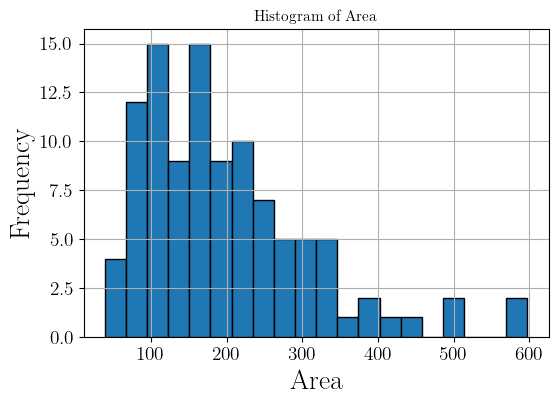

In [32]:
plt.figure(figsize=(6, 4))
plt.hist(X_df_prime['area'], bins=20, edgecolor='black')  # You can adjust the number of bins as needed
plt.title('Histogram of Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# CREATING MODEL

In [362]:
len(feature_dataframes_list)

9

In [352]:
feature_dataframes_list = [X_df_2yr_clean, X_df_2yr_frost_clean,X_df_2yr_lee_clean,X_df_2yr_temporal_clean,X_df_2yr_temporal_frost_clean,X_df_2yr_temporal_lee_clean,X_df_2yr_quegan_clean,X_df_2yr_quegan_frost_clean,X_df_2yr_quegan3d_clean]

timeseries_dataframes_list = [[df_series_2yr_gaps,df_series_2yr_random],[df_frost_gaps, df_frost_random],[df_lee_gaps, df_lee_random],[df_temporal_gaps,df_temporal_random],[df_temporal_lee_gaps, df_temporal_lee_random],[df_temporal_frost_gaps,df_temporal_frost_random],[df_quegan_gaps,df_quegan_random],[df_quegan_frost_gaps, df_quegan_frost_random],[df_quegan3d_gaps, df_quegan3d_random]]

In [360]:

def train_random_forest_and_plot_roc(df):
    # Separate features and target variable
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Train the random forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_probs)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [376]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

def train_random_forest_and_plot_roc(df, ax, title):
    # Separate features and target variable
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
    
    # Train the random forest model
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

def plot_all_rocs(dataframes_list):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(7, 7))
    axes = axes.flatten()
    
    # Loop through the dataframes and plot ROC curves
    for idx, df in enumerate(dataframes_list):
        df_name = f'DataFrame {idx+1}'
        train_random_forest_and_plot_roc(df, axes[idx], df_name)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()



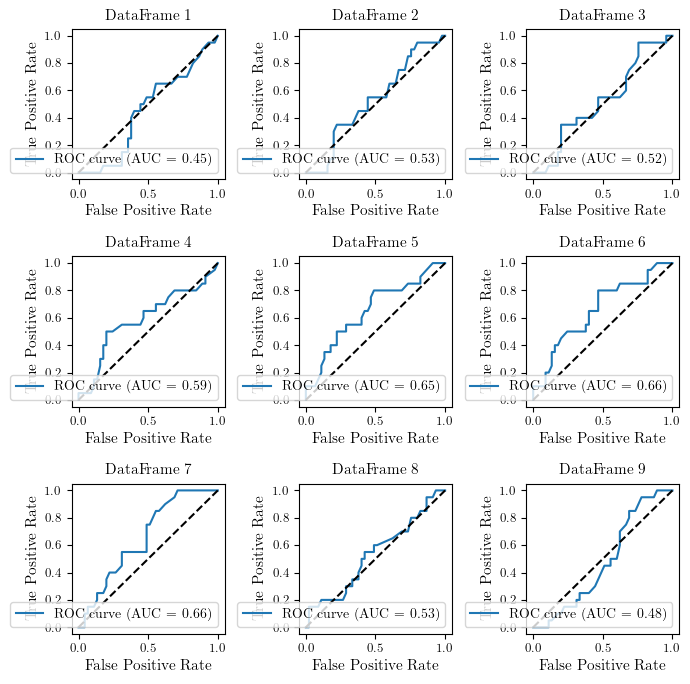

In [377]:
plot_all_rocs(feature_dataframes_list)

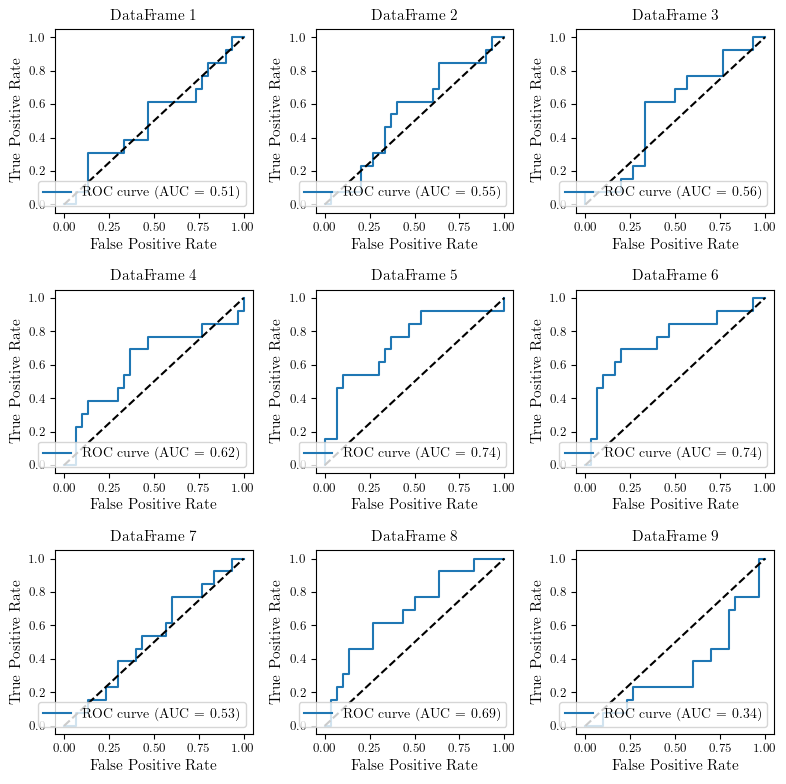

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
import xgboost as xgb

def train_xgboost_and_plot_roc(df, ax, title):
    # Separate features and target variable
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40)
    
    # Train the XGBoost model
    model = xgb.XGBClassifier(random_state=40, eval_metric='logloss', verbosity=0)
    model.fit(X_train, y_train)
    
    # Predict probabilities
    y_probs = model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

def plot_all_rocs(dataframes_list):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    
    # Loop through the dataframes and plot ROC curves
    for idx, df in enumerate(dataframes_list):
        df_name = f'DataFrame {idx+1}'
        train_xgboost_and_plot_roc(df, axes[idx], df_name)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage with your list of dataframes
plot_all_rocs(feature_dataframes_list)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:54:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:55:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:55:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:56:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:56:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:57:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


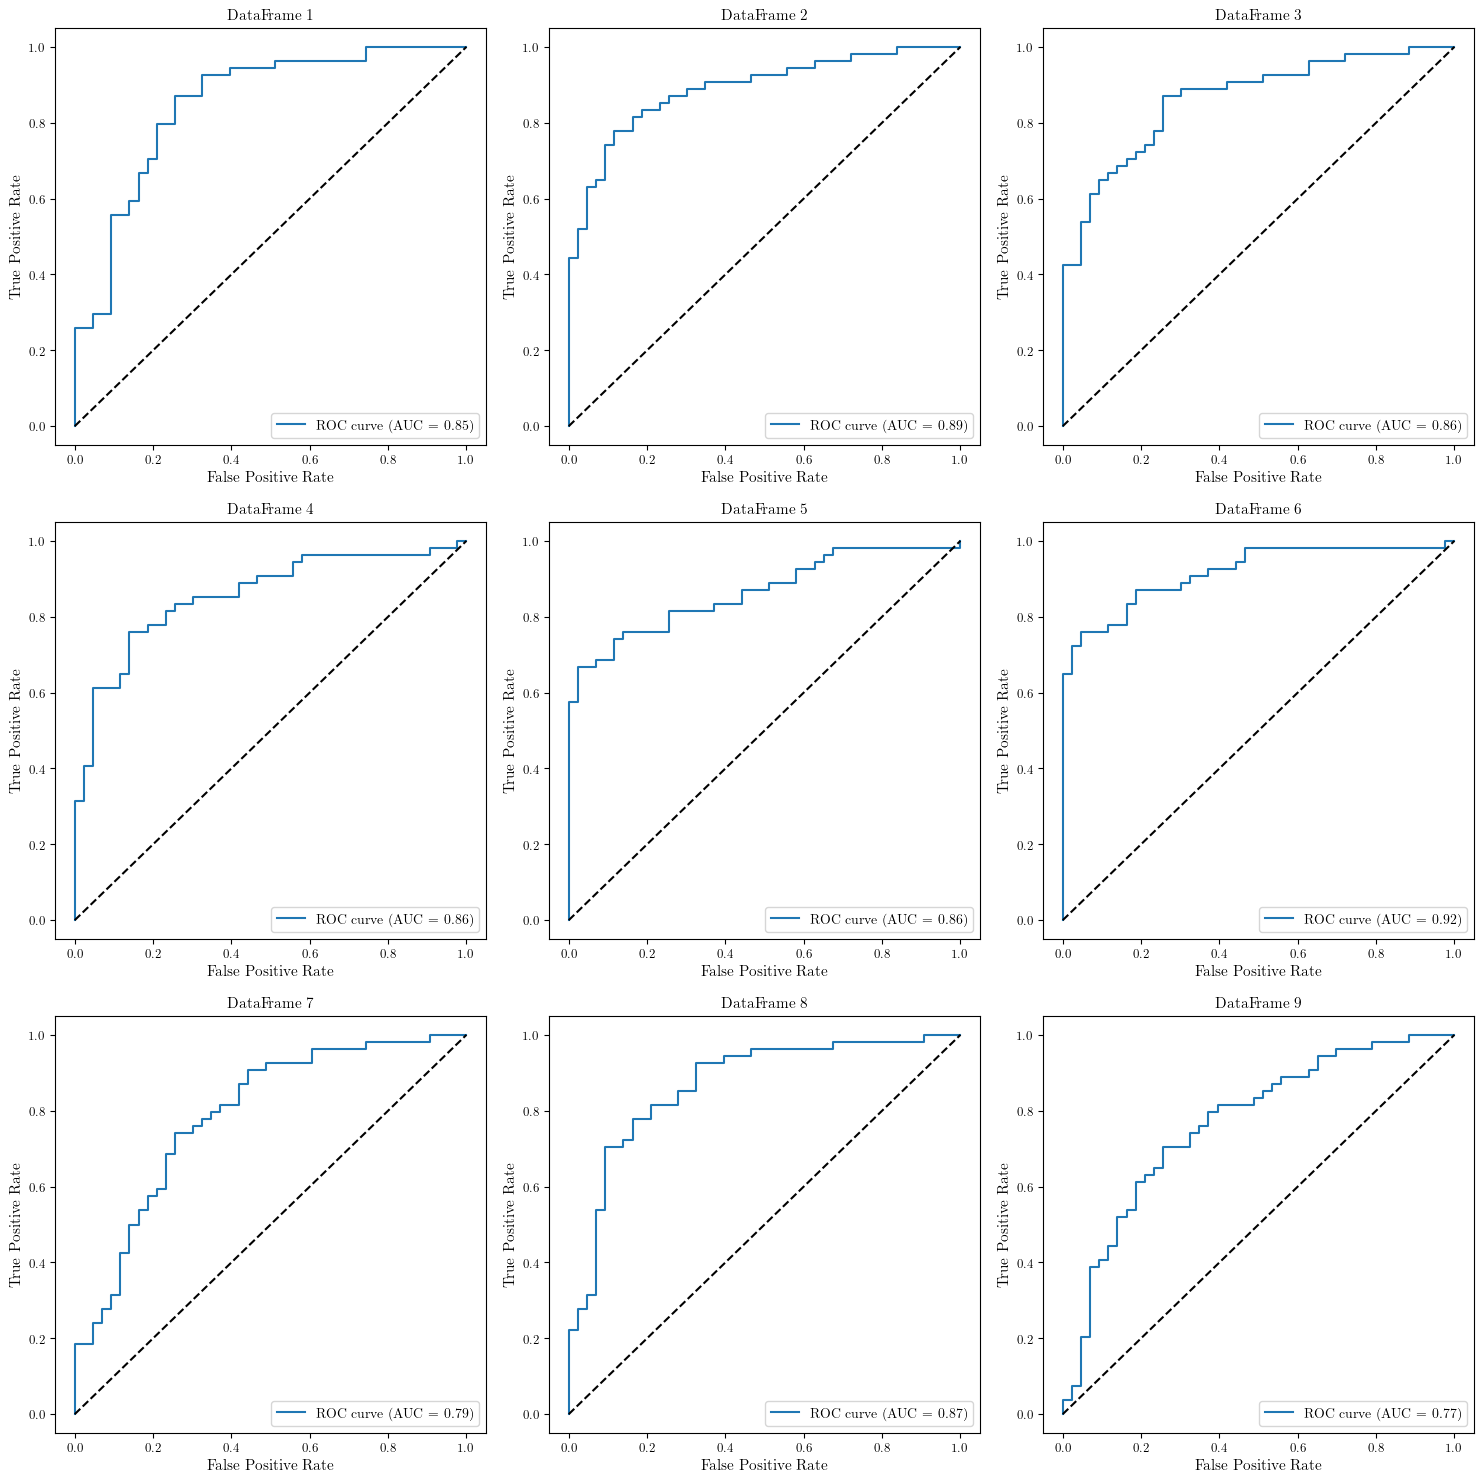

In [385]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE

def train_xgboost_and_plot_roc(df, ax, title):
    # Separate features and target variable
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=42)
    
    # Hyperparameter tuning using GridSearchCV
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0]
    }
    model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)
    
    # Get the best model from GridSearchCV
    best_model = grid_search.best_estimator_
    
    # Predict probabilities
    y_probs = best_model.predict_proba(X_test)[:, 1]
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    
    # Calculate AUC score
    auc_score = roc_auc_score(y_test, y_probs)
    
    # Plot ROC curve
    ax.plot(fpr, tpr, label=f'ROC curve (AUC = {auc_score:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

def plot_all_rocs(dataframes_list):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    
    # Loop through the dataframes and plot ROC curves
    for idx, df in enumerate(dataframes_list):
        df_name = f'DataFrame {idx+1}'
        train_xgboost_and_plot_roc(df, axes[idx], df_name)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Example usage with your list of dataframes
plot_all_rocs(feature_dataframes_list)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:09:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:10:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:11:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:11:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:12:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:13:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:13:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:14:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:14:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:15:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:15:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:16:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:18:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:20:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:21:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:22:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:23:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:24:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:25:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:26:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:27:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:29:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:31:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


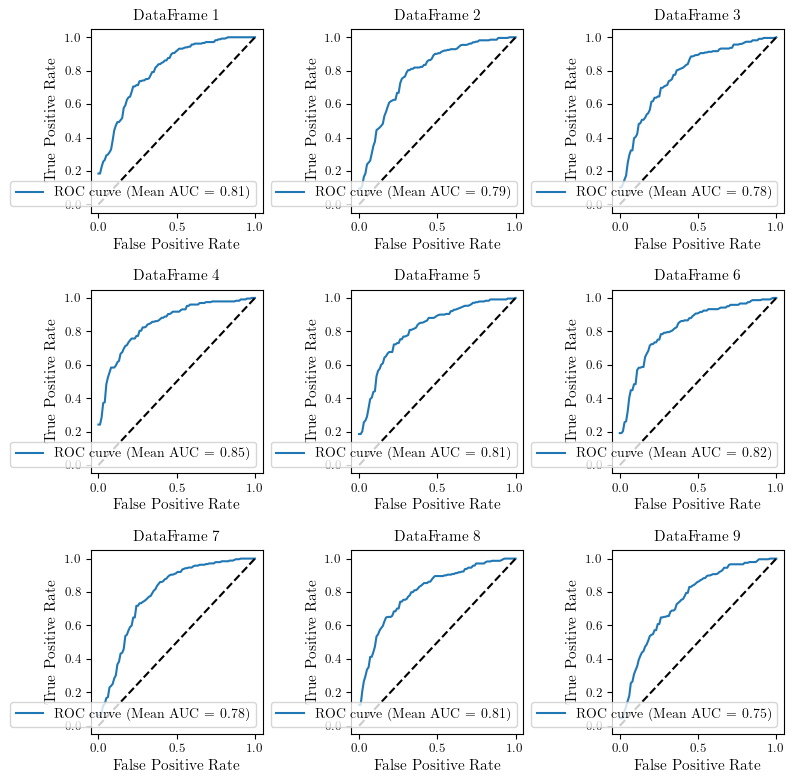

In [386]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import numpy as np

def train_xgboost_and_plot_roc(df, ax, title, random_states):
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    fprs, tprs, aucs = [], [], []
    
    for state in random_states:
        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=state)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=state)
        
        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
        model = xgb.XGBClassifier(random_state=state, eval_metric='logloss', use_label_encoder=False)
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Get the best model from GridSearchCV
        best_model = grid_search.best_estimator_
        
        # Predict probabilities
        y_probs = best_model.predict_proba(X_test)[:, 1]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_probs)
        
        # Calculate AUC score
        auc_score = roc_auc_score(y_test, y_probs)
        
        fprs.append(fpr)
        tprs.append(tpr)
        aucs.append(auc_score)
    
    # Calculate mean ROC curve
    mean_fpr = np.linspace(0, 1, 100)
    mean_tpr = np.mean([np.interp(mean_fpr, fprs[i], tprs[i]) for i in range(len(random_states))], axis=0)
    mean_auc = np.mean(aucs)
    
    # Plot ROC curve
    ax.plot(mean_fpr, mean_tpr, label=f'ROC curve (Mean AUC = {mean_auc:.2f})')
    ax.plot([0, 1], [0, 1], 'k--')  # Diagonal line
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

def plot_all_rocs(dataframes_list, random_states):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()
    
    # Loop through the dataframes and plot ROC curves
    for idx, df in enumerate(dataframes_list):
        df_name = f'DataFrame {idx+1}'
        train_xgboost_and_plot_roc(df, axes[idx], df_name, random_states)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

# Define a list of random states for averaging
random_states = [42, 52, 62, 72, 82]

# Example usage with your list of dataframes
plot_all_rocs(feature_dataframes_list, random_states)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:46:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:49:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:51:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:52:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:53:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:54:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:55:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:56:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:57:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:58:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:59:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:00:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:01:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:02:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:04:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:05:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:06:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:06:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:07:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:07:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:07:38] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:49:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:51:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\olive\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:158: UserWarning: [10:52:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

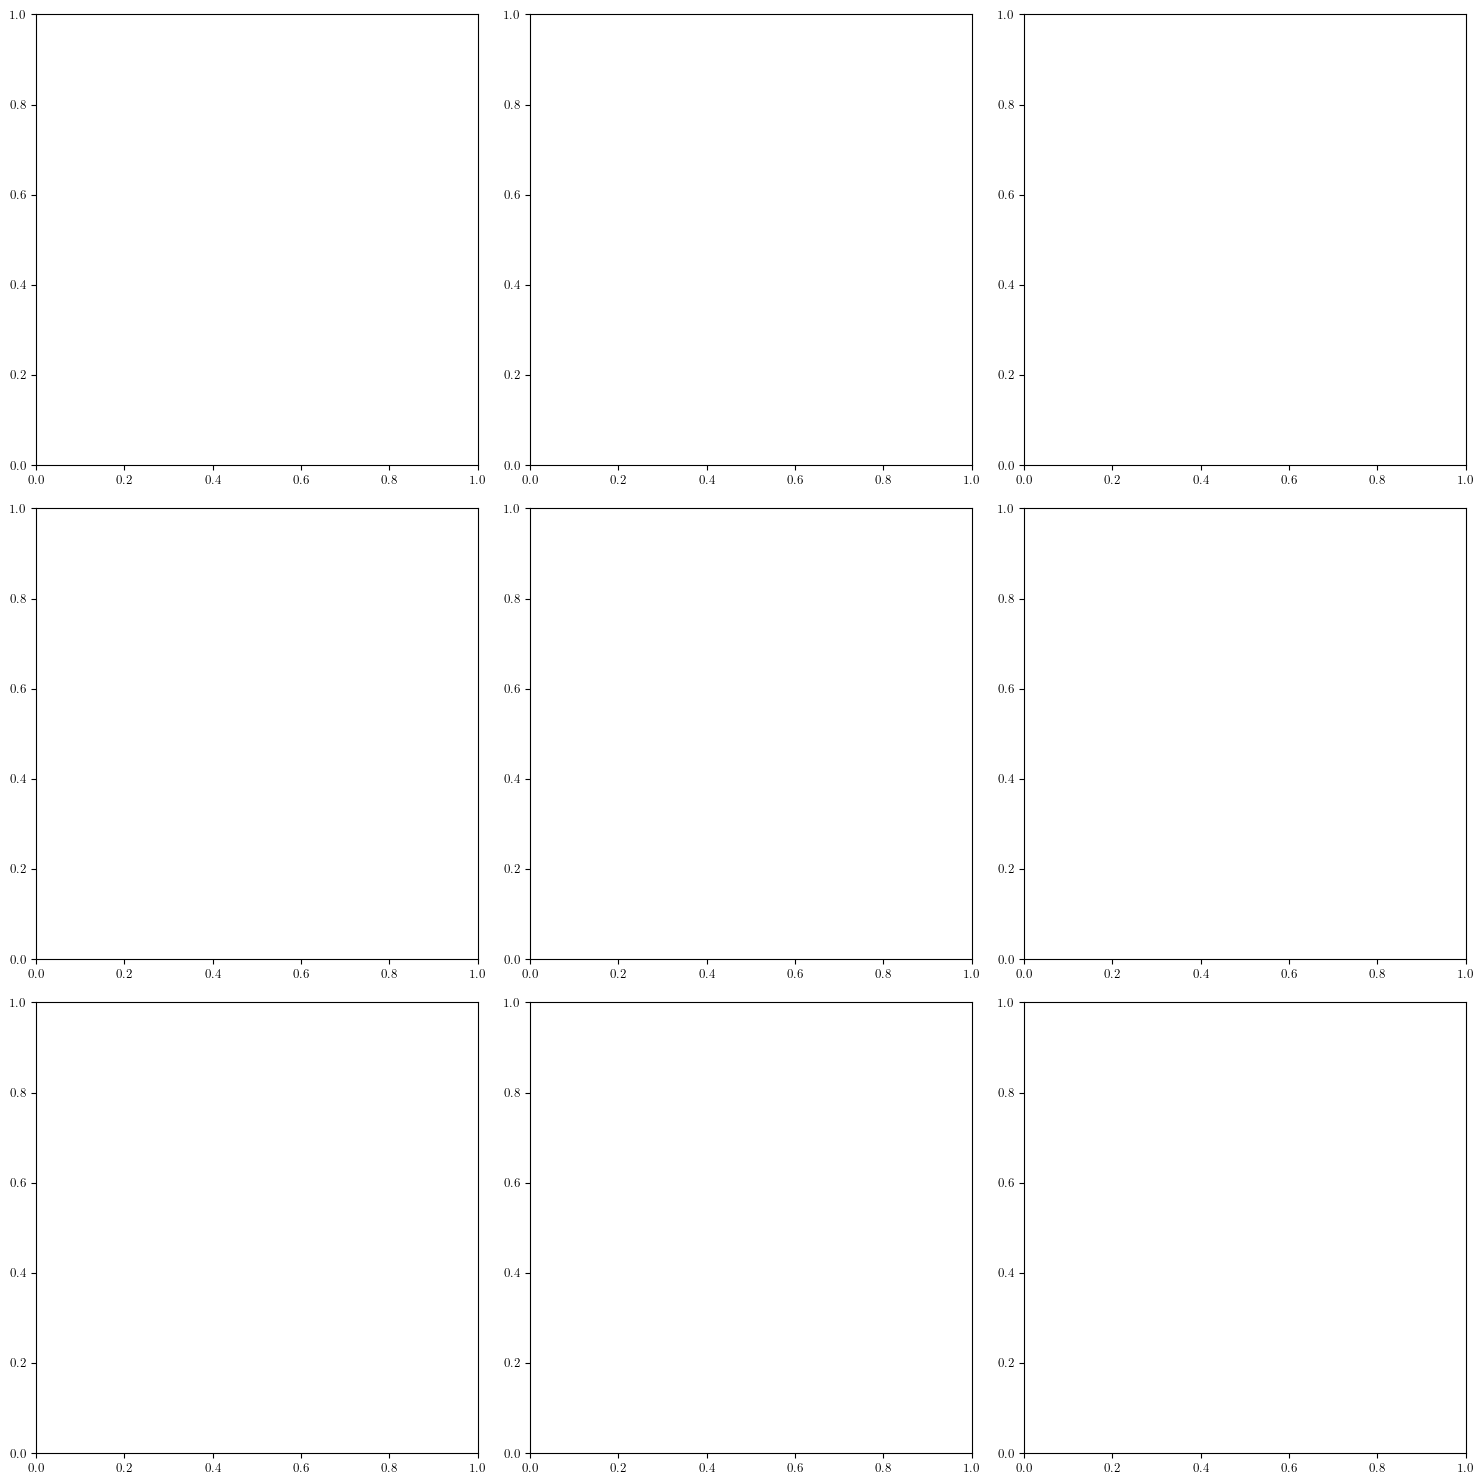

DataFrame 1:
  Random State 42: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
  Random State 52: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
  Random State 62: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
  Random State 72: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.8}
  Random State 82: {'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.6}
DataFrame 2:
  Random State 42: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 1.0}
  Random State 52: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 10, 'n_estimators': 100, 'subsample': 0.6}
  Random State 62: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'subsamp

In [387]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from imblearn.over_sampling import SMOTE
import numpy as np

def train_xgboost_and_collect_best_params(df, random_states):
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    best_params = []
    
    for state in random_states:
        # Handle class imbalance using SMOTE
        smote = SMOTE(random_state=state)
        X_resampled, y_resampled = smote.fit_resample(X, y)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=state)
        
        # Hyperparameter tuning using GridSearchCV
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0]
        }
        model = xgb.XGBClassifier(random_state=state, eval_metric='logloss', use_label_encoder=False)
        grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Get the best parameters from GridSearchCV
        best_params.append(grid_search.best_params_)
        
    return best_params

def evaluate_best_model(df, best_params, random_state):
    X = df.drop(columns=['name', 'gap'])
    y = df['gap']
    
    # Handle class imbalance using SMOTE
    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, y)
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=random_state)
    
    # Create a model with the best parameters
    model = xgb.XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss', use_label_encoder=False)
    model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = model.predict(X_test)
    
    # Calculate precision and accuracy
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    
    return precision, accuracy

def plot_all_rocs(dataframes_list, random_states):
    # Create a 3x3 grid of subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    axes = axes.flatten()
    
    # Dictionary to store best parameters for each dataframe and each seed
    all_best_params = {}
    all_metrics = {}
    
    # Loop through the dataframes and plot ROC curves
    for idx, df in enumerate(dataframes_list):
        df_name = f'DataFrame {idx+1}'
        best_params = train_xgboost_and_collect_best_params(df, random_states)
        all_best_params[df_name] = best_params
        
        # Evaluate model with best parameters
        metrics = []
        for state, params in zip(random_states, best_params):
            precision, accuracy = evaluate_best_model(df, params, state)
            metrics.append({'random_state': state, 'precision': precision, 'accuracy': accuracy})
        all_metrics[df_name] = metrics
        
    # Adjust layout
    plt.tight_layout()
    plt.show()
    
    return all_best_params, all_metrics

# Define a list of random states for averaging
random_states = [42, 52, 62, 72, 82]

# Example usage with your list of dataframes
all_best_params, all_metrics = plot_all_rocs(feature_dataframes_list, random_states)

# Print the best parameters and metrics for each dataframe and each random state
for df_name, params in all_best_params.items():
    print(f"{df_name}:")
    for state, param in zip(random_states, params):
        print(f"  Random State {state}: {param}")

for df_name, metrics in all_metrics.items():
    print(f"{df_name}:")
    for metric in metrics:
        print(f"  Random State {metric['random_state']}: Precision = {metric['precision']:.2f}, Accuracy = {metric['accuracy']:.2f}")
